In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import json
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

import glob
import re

from IPython.display import display

In [2]:
sns.palettes.SEABORN_PALETTES
def get_shared_y_axes(fig, gs):
    ax = []
    ncols = gs.get_geometry()[1]
    for i in range(ncols):
        if i != 0:
            axi = plt.Subplot(fig, gs[i], sharey=ax[0])
            #plt.setp(axi.get_yticklabels(), visible=False)
        else:
            axi = plt.Subplot(fig, gs[i])
        fig.add_subplot(axi)
        ax.append(axi)
    return ax

def get_grid_axes(fig, gs):
    ax = []
    nrows, ncols = gs.get_geometry()
    for i in range(nrows):
        ax_row = []
        for j in range(ncols):
            axi = plt.Subplot(fig, gs[i,j])
            ax_row.append(axi)
            fig.add_subplot(axi)
        ax.append(ax_row)
    return np.asarray(ax)

In [3]:
%%time
df = pd.read_csv("./data/joined_data_all.txt", sep="\t", parse_dates=["created_at", "u_created_at"])
df["opinionated"] = df.label != "neutral"
df["followers_friends"] = (df[u'u_followers'] + 1)/(df[u'u_friends'] + 1)
df["statuses_followers"] = (df[u'u_statuses'] + 1)/(df[u'u_followers'] + 1)
df["statuses_friends"] = (df[u'u_statuses'] + 1)/(df[u'u_friends'] + 1)
df["user_age"] = (df.created_at - df.u_created_at).dt.round("D").apply(lambda x: (x.days))
df.dtypes

CPU times: user 1min 15s, sys: 80 ms, total: 1min 15s
Wall time: 1min 15s


In [4]:
df.pivot_table(index="dataset", columns=["datasplit", "label"], values="tid", aggfunc=len, margins=True)

datasplit         all                        dev                      test  \
label        negative  neutral positive negative neutral positive negative   
dataset                                                                      
airline        7660.0   2560.0   2038.0      NaN     NaN      NaN      NaN   
clarin        15952.0  26970.0  18745.0      NaN     NaN      NaN      NaN   
gop_debate     5876.0   2525.0   1629.0      NaN     NaN      NaN      NaN   
hcr               NaN      NaN      NaN    405.0   178.0    141.0    428.0   
obama_debate    994.0    983.0    631.0      NaN     NaN      NaN      NaN   
semeval           NaN      NaN      NaN    836.0  1779.0   1968.0   3531.0   
All           30482.0  33038.0  23043.0   1241.0  1957.0   2109.0   3959.0   

datasplit                         train                        All  
label         neutral positive negative neutral positive            
dataset                                                             
airline           NaN      NaN      NaN     NaN      NaN   12258.0  
clarin            NaN      NaN      NaN     NaN      NaN   61667.0  
gop_debate        NaN      NaN      NaN     NaN      NaN   10030.0  
hcr             156.0    133.0    326.0   192.0    172.0    2131.0  
obama_debate      NaN      NaN      NaN     NaN      NaN    2608.0  
semeval       11382.0   8784.0   2631.0  6250.0   5750.0   42911.0  
All           11538.0   8917.0   2957.0  6442.0   5922.0  131605.0

In [5]:
sns.set_palette(sns.color_palette(["#0000FF", "#000000", "#FF0000", "#00FF00"]))
sns.set_context('poster')
sns.set_style('ticks')

label_order = ["positive", "neutral", "negative",]
color_order= ["b", "k", "r"]

In [6]:
df.columns

Index(['tid', 'favorites', 'is_quote', 'is_reply', 'retweets', 'u_id',
       'u_created_at', 'u_followers', 'u_friends', 'u_lists', 'u_statuses',
       'u_verified', 'u_location', 'u_has_url', 'n_hashtags', 'n_symbols',
       'n_urls', 'n_mentions', 'created_at', 'dataset', 'datasplit',
       'language', 'label', 'opinionated', 'followers_friends',
       'statuses_followers', 'statuses_friends', 'user_age'],
      dtype='object')

In [7]:
df.created_at.head()

0   2008-09-27 01:00:06
1   2008-09-27 01:00:24
2   2008-09-27 01:00:32
3   2008-09-27 01:00:58
4   2008-09-27 01:01:13
Name: created_at, dtype: datetime64[ns]

In [8]:
df[["created_at", "u_created_at"]].describe()

,created_at,u_created_at
count,131605,131605
unique,124801,115731
top,2016-10-11 23:58:48,2013-03-04 05:42:16
freq,8,113
first,2008-09-27 01:00:06,2006-07-13 13:52:39
last,2016-10-11 23:59:59,2016-10-11 22:28:22


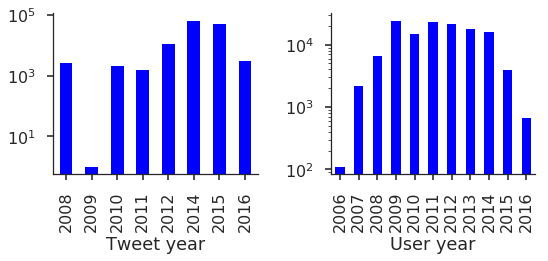

In [9]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
df.created_at.dt.year.value_counts().sort_index().plot(kind="bar", ax=ax[0])
ax[0].set_yscale("log")
ax[0].set_xlabel("Tweet year")

df.u_created_at.dt.year.value_counts().sort_index().plot(kind="bar", ax=ax[1])
ax[1].set_yscale("log")
ax[1].set_xlabel("User year")
sns.despine()
fig.tight_layout()

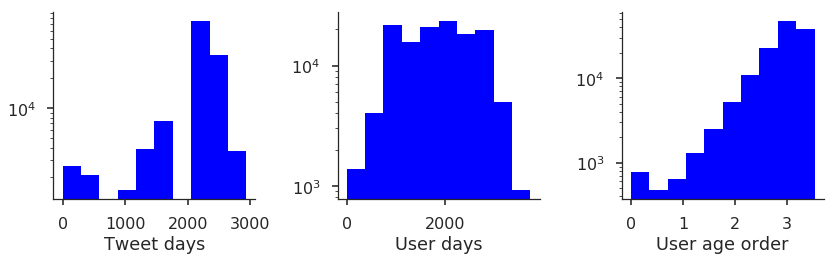

In [10]:
fig, ax = plt.subplots(1,3,figsize=(12,4))
#df.created_at.dt.year.value_counts().sort_index().plot(kind="bar", ax=ax[0])
ax[0].hist((df.created_at - df.created_at.min()).dt.round("D").apply(lambda x: x.days), log=True)
ax[0].set_yscale("log")
ax[0].set_xlabel("Tweet days")

ax[1].hist((df.u_created_at - df.u_created_at.min()).dt.round("D").apply(lambda x: x.days), log=True)
ax[1].set_yscale("log")
ax[1].set_xlabel("User days")


ax[2].hist(np.log10(df.user_age + 1), log=True)
ax[2].set_yscale("log")
ax[2].set_xlabel("User age order")

sns.despine()
fig.tight_layout()

In [11]:
df.dataset.value_counts()

clarin          61667
semeval         42911
airline         12258
gop_debate      10030
obama_debate     2608
hcr              2131
Name: dataset, dtype: int64

In [12]:
DATASET_LABELS={
    "clarin": "Clarin", 
    "semeval": "SemEval", 
    "airline": "Airline", 
    "gop_debate": "GOP", 
    "hcr": "Healthcare", 
    "obama_debate": "Obama", 
}

df.dataset = df.dataset.apply(lambda x: DATASET_LABELS[x])
df.dataset.value_counts()

Clarin        61667
SemEval       42911
Airline       12258
GOP           10030
Obama          2608
Healthcare     2131
Name: dataset, dtype: int64

In [13]:
df.groupby(["dataset", "language", "datasplit"])["tid"].count().to_frame()

tid
dataset    language datasplit       
Airline    english  all        12258
Clarin     english  all        61667
GOP        english  all        10030
Healthcare english  dev          724
                    test         717
                    train        690
Obama      english  all         2608
SemEval    arabic   test         594
                    train       2386
           english  dev         4583
                    test       23103
                    train      12245

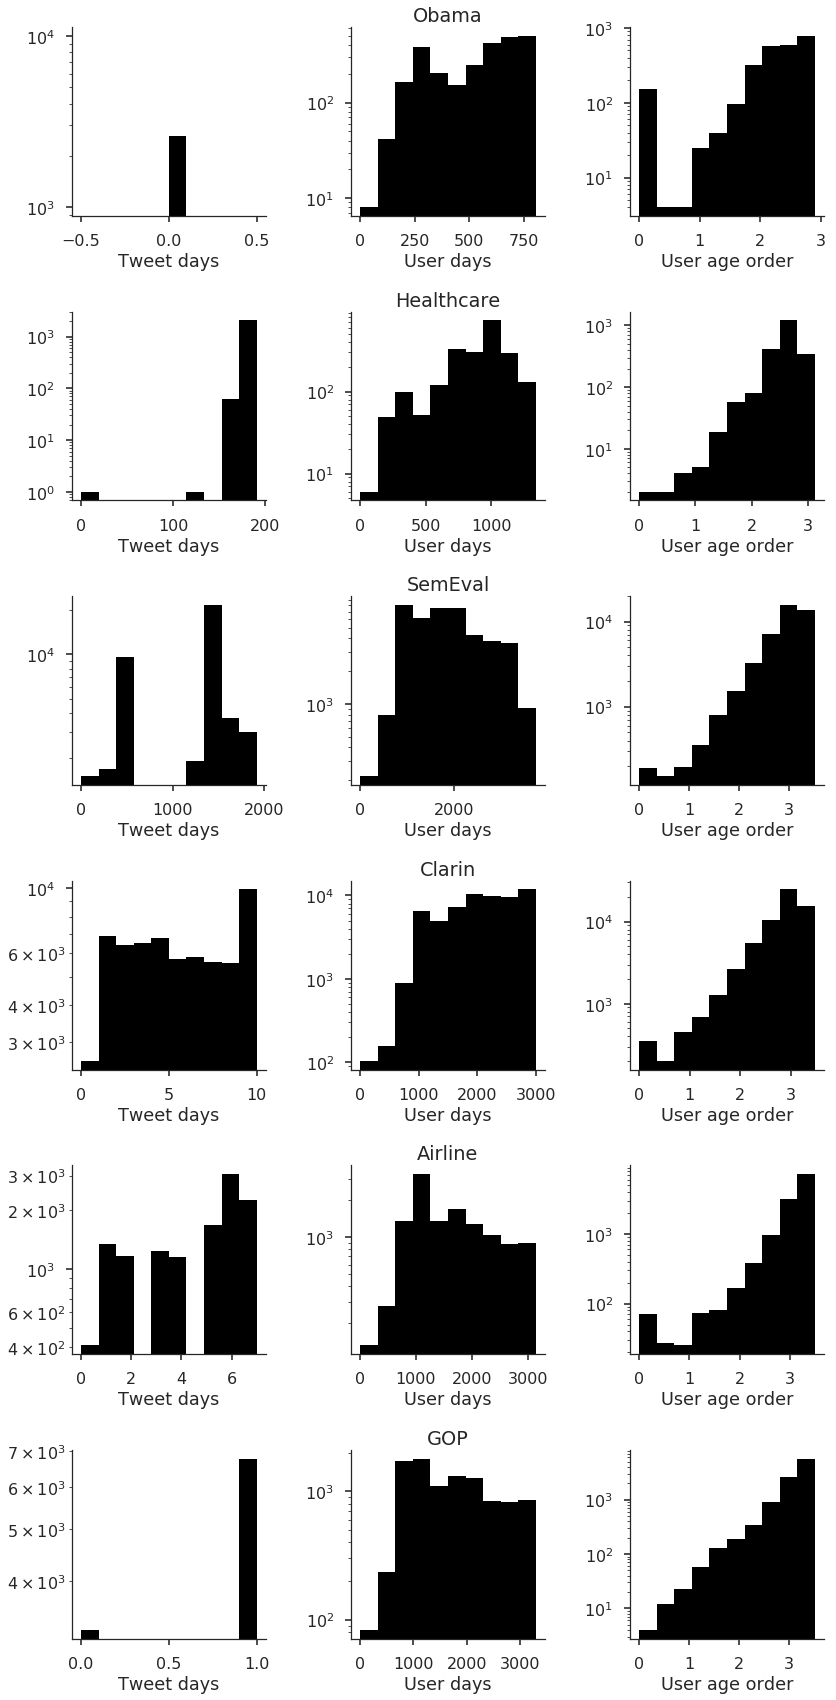

In [14]:
fig, ax = plt.subplots(6,3,figsize=(12,24))
for i, d in enumerate(df.dataset.unique()):
    #df.created_at.dt.year.value_counts().sort_index().plot(kind="bar", ax=ax[0])
    ax[i, 0].hist((df[df.dataset == d].created_at
                   - df[df.dataset == d].created_at.min()).dt.round("D").apply(lambda x: x.days),
                  color="k",
                  log=True)
    ax[i, 0].set_yscale("log")
    ax[i, 0].set_xlabel("Tweet days")

    ax[i, 1].hist((df[df.dataset == d].u_created_at
                   - df[df.dataset == d].u_created_at.min()).dt.round("D").apply(lambda x: x.days),
                  color="k",
                  log=True)
    ax[i, 1].set_yscale("log")
    ax[i, 1].set_xlabel("User days")
    ax[i, 1].set_title(d)


    ax[i, 2].hist(np.log10(df[df.dataset == d].user_age + 1),
                  color="k",
                  log=True)
    ax[i, 2].set_yscale("log")
    ax[i, 2].set_xlabel("User age order")

sns.despine()
fig.tight_layout()

/homed/content/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:2009: RuntimeWarning: overflow encountered in power
  ticklocs = b ** decades


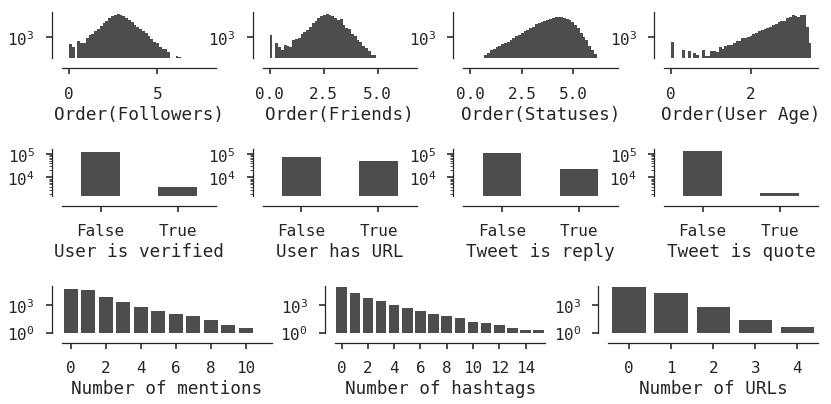

In [15]:
with sns.axes_style(rc={"font.family": "monospace"}):

    fig = plt.figure(figsize=(12,6))
    gs_main = gridspec.GridSpec(3,1)
    gs_top = gridspec.GridSpecFromSubplotSpec(1,4, subplot_spec=gs_main[0])
    gs_middle = gridspec.GridSpecFromSubplotSpec(1,4, subplot_spec=gs_main[1])
    gs_bottom = gridspec.GridSpecFromSubplotSpec(1,3, subplot_spec=gs_main[2])

    ax = get_shared_y_axes(fig, gs_top)

    df.assign(
        u_statuses = lambda x: np.log10(x.u_statuses + 1),
        u_followers = lambda x: np.log10(x.u_followers + 1),
        u_friends = lambda x: np.log10(x.u_friends + 1),
        user_age = lambda x: np.log10(x.user_age + 1),
    ).hist(column=["u_statuses", "u_followers", "u_friends", "user_age"],
        bins=50, ax=ax, color="0.3", grid=False, log=True)

    for i,l in enumerate([
        "Followers", "Friends",
        "Statuses", "User Age"
    ]):
        ax[i].set_xlabel("Order({})".format(l))
        ax[i].set_title("")

    ax = get_shared_y_axes(fig, gs_middle)

    features = ["u_verified", "u_has_url", "is_reply", "is_quote"]
    x_labels = ["User is verified", "User has URL", "Tweet is reply", "Tweet is quote"]
    for i, (feature, label) in enumerate(zip(features, x_labels)):
        df[feature].value_counts().plot(kind="bar", ax=ax[i], color="0.3")
        ax[i].set_xlabel(label)
        ax[i].set_yscale("log")    


    ax = get_shared_y_axes(fig, gs_bottom)

    for i, variable in enumerate(["n_mentions", "n_hashtags", "n_urls"]):
        sns.countplot(x=variable, data=df.assign(**{
            #variable: lambda x: np.round(np.log10(x[variable]+1), 1)
                }
        ), color="0.3", ax=ax[i])
        ax[i].set_yscale("log")
        ax[i].set_ylabel("")
        ax[i].set_ylim([1,10**(5.1)])
        if i < 2:
            plt.sca(ax[i])
            tick_labels = range(0,int(ax[i].get_xlim()[1]),2)
            plt.xticks(tick_labels, tick_labels)

    #tick_labels = ax[1].get_xticklabels()
    ax[0].set_xlabel("Number of mentions")
    ax[1].set_xlabel("Number of hashtags")
    ax[2].set_xlabel("Number of URLs")  

    sns.despine(offset=10)
    fig.tight_layout()
    plt.savefig("figures/All_dists.pdf", bbox_inches="tight")

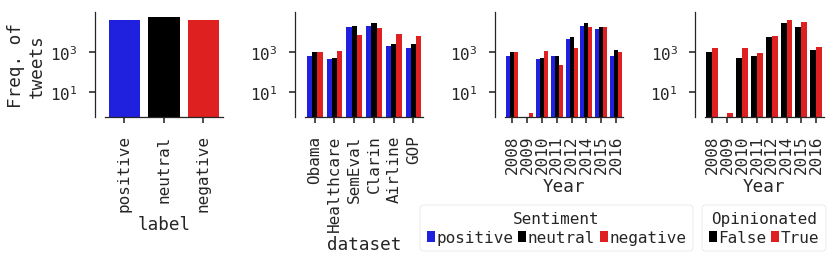

In [16]:
with sns.axes_style(rc={"font.family": "monospace"}):
    fig, ax = plt.subplots(1,4, sharey=True, figsize=(12,4))

    g = sns.countplot(x="label",
                      order=label_order,
                      data=df, ax=ax[0])
    #ax[0].set_yscale("log")
    ax[0].set_ylabel("Freq. of\ntweets")
    g.set_xticklabels(g.get_xticklabels(), rotation=90)
    g.spines['right'].set_visible(False)
    g.spines['top'].set_visible(False)
    g.spines['left'].set_position(('outward', 10))

    g = sns.countplot(x="dataset", hue="label",
                  hue_order=label_order,
                  data=df, ax=ax[1])
    ax[1].set_yscale("log")
    ax[1].set_ylabel("")
    g.set_xticklabels(g.get_xticklabels(), rotation=90)
    g.spines['right'].set_visible(False)
    g.spines['top'].set_visible(False)
    g.spines['left'].set_position(('outward', 10))

    leg1 = g.legend(
        bbox_to_anchor=(0.66, 0.05),
        loc="lower center",
        ncol=3,
        frameon=True,
        labelspacing=0.2, columnspacing=0.3, handletextpad=0.1,
        handlelength=0.5,
        bbox_transform=plt.gcf().transFigure
    )
    leg1.set_title("Sentiment", prop = {'size':'small'})
             #bbox_transform=plt.gcf().transFigure,
             #ncol=3, mode="expand"
    #        )
    #leg1.remove()

    g = sns.countplot(x="year", hue="label",
                  hue_order=label_order,
                  data=df.assign(
            year=lambda x: x.created_at.dt.year,
        ), ax=ax[2])
    leg = g.legend(loc='upper left')
    leg.remove()
    #g.legend(bbox_to_anchor=(1., 0.5))
    g.set_xticklabels(g.get_xticklabels(), rotation=90)
    #ax[1].legend(loc='upper left')
    ax[2].set_xlabel("Year")
    ax[2].set_ylabel("")
    ax[2].set_yscale("log")
    g.spines['right'].set_visible(False)
    g.spines['top'].set_visible(False)
    g.spines['left'].set_position(('outward', 10))
    
    with sns.color_palette(["#000000", "#FF0000", "#00FF00", "#0000FF"]):
        g = sns.countplot(x="year", hue="opinionated", data=df.assign(
                year=lambda x: x.created_at.dt.year,
                u_statuses = lambda x: np.log10(x.u_statuses + 1),
            ), ax=ax[3])
        g.set_xticklabels(g.get_xticklabels(), rotation=90)
        leg2 = g.legend(
            bbox_to_anchor=(0.9, 0.05),
            loc="lower center",
            ncol=2,
            frameon=True,
            labelspacing=0.2, columnspacing=0.3, handletextpad=0.1,
            handlelength=0.5,
            bbox_transform=plt.gcf().transFigure
        )
        leg2.set_title("Opinionated", prop = {'size':'small'})
        #leg2.remove()
        ax[3].set_xlabel("Year")
        ax[3].set_ylabel("")
        ax[3].set_yscale("log")
        g.spines['right'].set_visible(False)
        g.spines['top'].set_visible(False)
        g.spines['left'].set_position(('outward', 10))


    #sns.despine(offset=10)
    fig.tight_layout()
    # 
    plt.savefig(
        "figures/Label_dists.pdf",
        bbox_inches="tight",
        bbox_extra_artists=[leg1, leg2]
    )

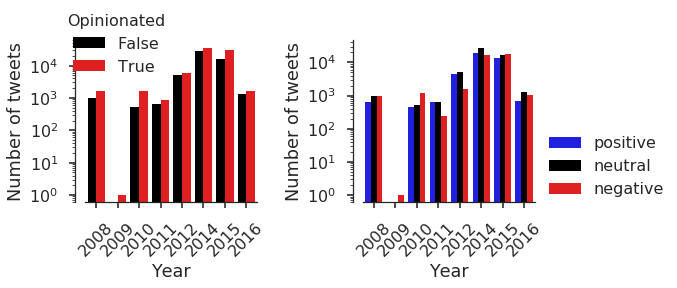

In [17]:
fig, ax = plt.subplots(1,2, figsize=(8,4))

with sns.color_palette(["#000000", "#FF0000", "#00FF00", "#0000FF"]):
    g = sns.countplot(x="year", hue="opinionated", data=df.assign(
            year=lambda x: x.created_at.dt.year,
            u_statuses = lambda x: np.log10(x.u_statuses + 1),
        ), ax=ax[0])
    g.set_xticklabels(g.get_xticklabels(), rotation=45)
    leg = g.legend(bbox_to_anchor=(0.55, 0.7))
    leg.set_title("Opinionated", prop = {'size':'small'})
    ax[0].set_xlabel("Year")
    ax[0].set_ylabel("Number of tweets")
    ax[0].set_yscale("log")
    g.spines['right'].set_visible(False)
    g.spines['top'].set_visible(False)
    g.spines['left'].set_position(('outward', 10))


g = sns.countplot(x="year", hue="label",
              hue_order=label_order,
              data=df.assign(
        year=lambda x: x.created_at.dt.year,
    ), ax=ax[1])
#g.legend(loc='upper left')
g.legend(bbox_to_anchor=(1., 0.5))
g.set_xticklabels(g.get_xticklabels(), rotation=45)
#ax[1].legend(loc='upper left')
ax[1].set_xlabel("Year")
ax[1].set_ylabel("Number of tweets")
ax[1].set_yscale("log")
g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)
g.spines['left'].set_position(('outward', 10))

fig.tight_layout()

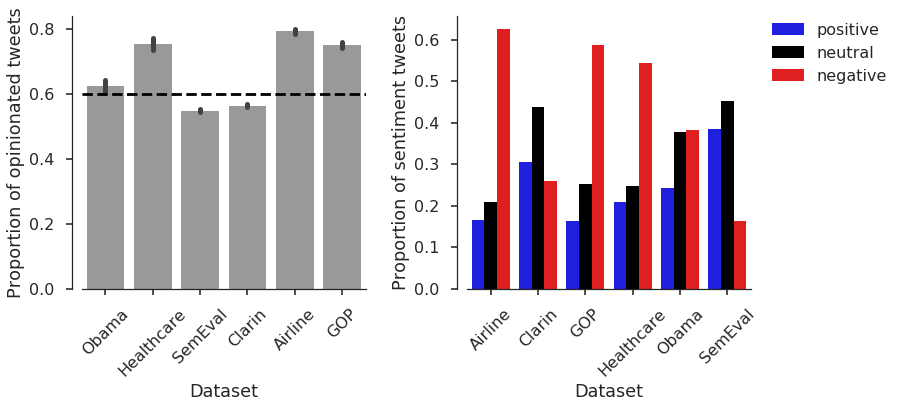

In [18]:
fig, ax = plt.subplots(1,2, figsize=(11,6))

g = sns.barplot(x="data_name", y="opinionated", #hue="datasplit",
            estimator=np.mean,
            color="0.6",
            data=df.assign(
        u_statuses = lambda x: np.round(np.log10(x.u_statuses + 1)),
        #data_name=lambda x: x.dataset.str.cat(x.datasplit, sep="-")
        data_name=lambda x: x.dataset
        #p_label = lambda x: x.label == "negative",
    ), ax=ax[0])
#plt.sca(ax[0])
#plt.xticks(rotation=90)
g.set_xticklabels(g.get_xticklabels(), rotation=45)

ax[0].axhline(y=df.opinionated.mean(), linestyle="--", color="k")
ax[0].set_xlabel("Dataset")
ax[0].set_ylabel("Proportion of opinionated tweets")
g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)
g.spines['left'].set_position(('outward', 10))


df_t = df.pivot_table(index=df.dataset,
    #index=df.dataset.str.cat(df.datasplit, sep="-"),
                      columns=["label"],
                      values="tid",
                      aggfunc=len)
df_t = df_t.divide(df_t.sum(axis=1), axis=0).reset_index()

g = sns.barplot(x="dataset", y="value", hue="label",
            hue_order=label_order,
            data=pd.melt(df_t, id_vars="dataset"), ax=ax[1])
#plt.sca(ax[1])
#plt.xticks(rotation=90)
g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax[1].set_xlabel("Dataset")
ax[1].set_ylabel("Proportion of sentiment tweets")
g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)
g.spines['left'].set_position(('outward', 10))

fig.tight_layout()

In [19]:
df_t = df.pivot_table(index=df.dataset,
                      columns=["label"],
                      values="tid",
                      aggfunc=len)
df_t = df_t.divide(df_t.sum(axis=1), axis=0).reset_index()
df_t

label,dataset,negative,neutral,positive
0,Airline,0.624898,0.208843,0.166259
1,Clarin,0.258680,0.437349,0.303971
2,GOP,0.585842,0.251745,0.162413
3,Healthcare,0.543876,0.246832,0.209291
4,Obama,0.381135,0.376917,0.241948
5,SemEval,0.163082,0.452355,0.384563


## Visualize data distributions

/homed/content/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:2009: RuntimeWarning: overflow encountered in power
  ticklocs = b ** decades


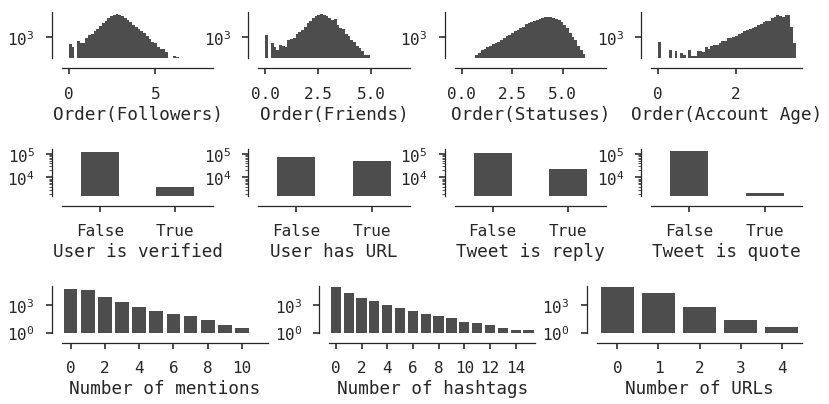

In [20]:
with sns.axes_style(rc={"font.family": "monospace"}):

    fig = plt.figure(figsize=(12,6))
    gs_main = gridspec.GridSpec(3,1)
    gs_top = gridspec.GridSpecFromSubplotSpec(1,4, subplot_spec=gs_main[0])
    gs_middle = gridspec.GridSpecFromSubplotSpec(1,4, subplot_spec=gs_main[1])
    gs_bottom = gridspec.GridSpecFromSubplotSpec(1,3, subplot_spec=gs_main[2])

    ax = get_shared_y_axes(fig, gs_top)

    df.assign(
        u_statuses = lambda x: np.log10(x.u_statuses + 1),
        u_followers = lambda x: np.log10(x.u_followers + 1),
        u_friends = lambda x: np.log10(x.u_friends + 1),
        user_age = lambda x: np.log10(x.user_age + 1),
    ).hist(column=["u_statuses", "u_followers", "u_friends", "user_age"],
        bins=50, ax=ax, color="0.3", grid=False, log=True)

    for i,l in enumerate([
        "Followers", "Friends",
        "Statuses", "Account Age"
    ]):
        ax[i].set_xlabel("Order({})".format(l))
        ax[i].set_title("")

    ax = get_shared_y_axes(fig, gs_middle)

    features = ["u_verified", "u_has_url", "is_reply", "is_quote"]
    x_labels = ["User is verified", "User has URL", "Tweet is reply", "Tweet is quote"]
    for i, (feature, label) in enumerate(zip(features, x_labels)):
        df[feature].value_counts().plot(kind="bar", ax=ax[i], color="0.3")
        ax[i].set_xlabel(label)
        ax[i].set_yscale("log")    


    ax = get_shared_y_axes(fig, gs_bottom)

    for i, variable in enumerate(["n_mentions", "n_hashtags", "n_urls"]):
        sns.countplot(x=variable, data=df.assign(**{
            #variable: lambda x: np.round(np.log10(x[variable]+1), 1)
                }
        ), color="0.3", ax=ax[i])
        ax[i].set_yscale("log")
        ax[i].set_ylabel("")
        ax[i].set_ylim([1,10**(5.1)])
        if i < 2:
            plt.sca(ax[i])
            tick_labels = range(0,int(ax[i].get_xlim()[1]),2)
            plt.xticks(tick_labels, tick_labels)

    #tick_labels = ax[1].get_xticklabels()
    ax[0].set_xlabel("Number of mentions")
    ax[1].set_xlabel("Number of hashtags")
    ax[2].set_xlabel("Number of URLs")  

    sns.despine(offset=10)
    fig.tight_layout()
    plt.savefig("figures/All_dists.pdf", bbox_inches="tight")

In [21]:
df[["statuses_followers", "statuses_friends", "followers_friends", "u_statuses"]].describe()

,statuses_followers,statuses_friends,followers_friends,u_statuses
count,131605.000000,1.316050e+05,1.316050e+05,1.316050e+05
mean,123.665617,1.763250e+03,1.980637e+02,4.072323e+04
std,3511.249524,4.194644e+04,1.357753e+04,1.048886e+05
min,0.000182,5.008970e-03,2.663116e-03,0.000000e+00
25%,5.983333,6.610503e+00,6.695842e-01,3.450000e+03
50%,17.345609,2.158065e+01,1.142298e+00,1.341400e+04
75%,41.647321,6.659234e+01,2.198587e+00,4.017700e+04
max,874476.000000,6.510542e+06,2.315171e+06,6.510541e+06


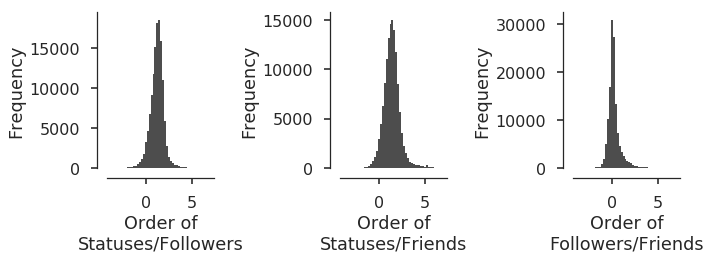

In [22]:
ax = df.assign(**{
    "statuses_followers": lambda x: np.log10(x["statuses_followers"]),
    "statuses_friends": lambda x: np.log10(x["statuses_friends"]),
    "followers_friends": lambda x: np.log10(x["followers_friends"]),
})[["statuses_followers", "statuses_friends", "followers_friends"]
  ].plot(kind="hist", bins=50, layout=(1,3),
         subplots=True, legend=False, #sharey=True,
         grid=False, figsize=(10,4), color="0.3",
       )

ax[0, 0].set_xlabel("Order of\nStatuses/Followers")
ax[0, 1].set_xlabel("Order of\nStatuses/Friends")
ax[0, 2].set_xlabel("Order of\nFollowers/Friends")

#ax[0, 0].set_title("")
#ax[0, 1].set_title("")
#ax[0, 2].set_title("")

sns.despine(offset=10)
plt.tight_layout()


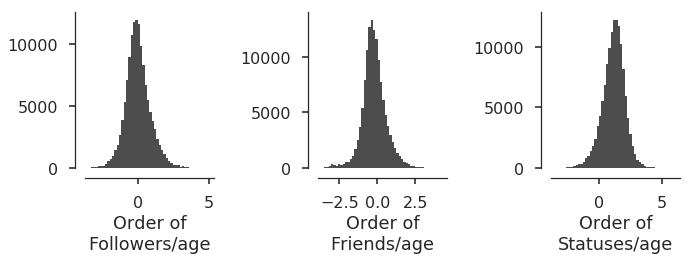

In [23]:
val_cols = ["u_statuses", "u_followers", "u_friends"]

ax = df.assign(**{
        k: np.log10((df[k] + 1)/(df.user_age+1))
        for k in val_cols
    })[val_cols].hist(
    bins=50, layout=(1,3),
    grid=False, figsize=(10,4), log=False, color="0.3")

ax[0, 0].set_xlabel("Order of\nFollowers/age")
ax[0, 1].set_xlabel("Order of\nFriends/age")
ax[0, 2].set_xlabel("Order of\nStatuses/age")

for i in range(3):
    pass
    ax[0, i].set_title("")
    #ax[0, i].set_xscale("log")
    

sns.despine(offset=10)
plt.tight_layout()


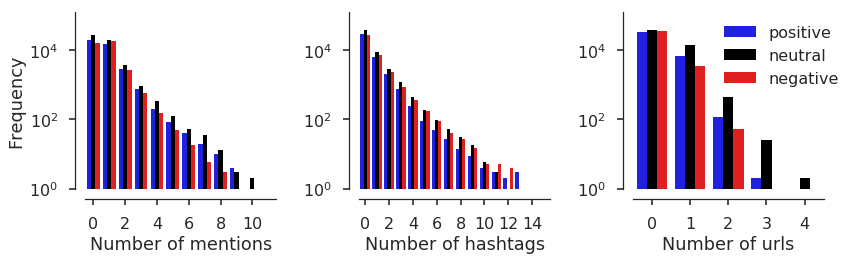

In [24]:
fig, ax = plt.subplots(1,3, sharey=False, figsize=(12,4))
for i, variable in enumerate(["n_mentions", "n_hashtags", "n_urls"]):
    sns.countplot(x=variable, hue="label", data=df.assign(**{
        #variable: lambda x: np.round(np.log10(x[variable]+1), 1)
            }
    ),
                  #color="k",
                  hue_order=label_order,
                  ax=ax[i])
    ax[i].set_yscale("log")
    ax[i].set_ylim([1,10**(5.1)])
    if i < 2:
        plt.sca(ax[i])
        tick_labels = range(0,int(ax[i].get_xlim()[1]),2)
        plt.xticks(tick_labels, tick_labels)

    
ax[0].set_xlabel("Number of mentions")
ax[1].set_xlabel("Number of hashtags")
ax[2].set_xlabel("Number of urls")    

for i in range(3):
    ax[i].legend().set_visible(False)
    ax[i].set_ylabel("")
    
ax[0].set_ylabel("Frequency")    
ax[i].legend(bbox_to_anchor=(0.4, 0.5))

sns.despine(offset=10)
fig.tight_layout()

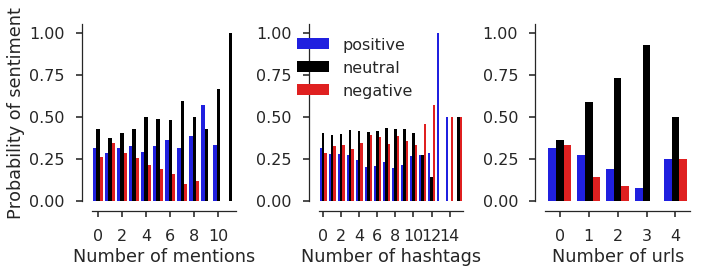

In [25]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(10,4))
for i, variable in enumerate(["n_mentions", "n_hashtags", "n_urls"]):
    df_t = df.pivot_table(index=variable,
                      columns=["label"],
                      values="tid",
                      aggfunc=len)
    df_t = df_t.divide(df_t.sum(axis=1), axis=0).reset_index()

    g = sns.barplot(x=variable, y="value", hue="label",
                hue_order=label_order,
                data=pd.melt(df_t, id_vars=variable), ax=ax[i])
    #ax[i].set_ylim([1,10**(5.1)])
    if i < 2:
        plt.sca(ax[i])
        tick_labels = range(0,int(ax[i].get_xlim()[1]),2)
        plt.xticks(tick_labels, tick_labels)

    
ax[0].set_xlabel("Number of mentions")
ax[1].set_xlabel("Number of hashtags")
ax[2].set_xlabel("Number of urls") 

for i in range(3):
    ax[i].legend().set_visible(False)
    ax[i].set_ylabel("")
ax[1].legend(bbox_to_anchor=(0.75, 0.5))
ax[0].set_ylabel("Probability of sentiment")

sns.despine(offset=10)
fig.tight_layout()  

Obama
Healthcare
SemEval
Clarin
Airline
GOP


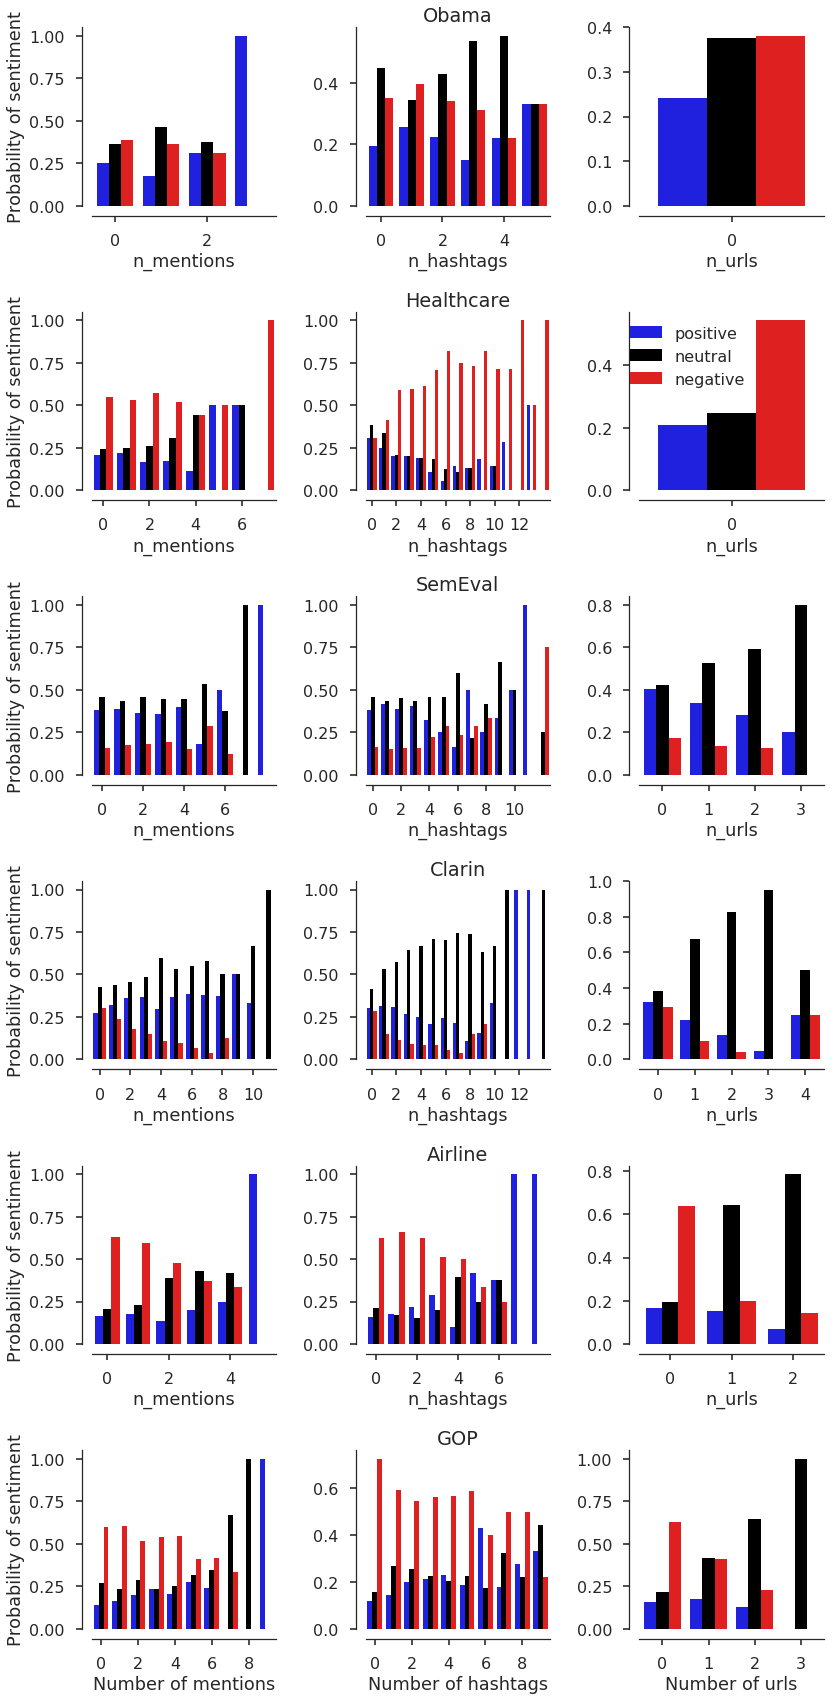

In [26]:
fig, ax = plt.subplots(6,3, figsize=(12,4*6))
val_cols = ["n_mentions", "n_hashtags", "n_urls"]
x_labels = ["statuses", "followers", "friends"]

for i, dataset in enumerate(df.dataset.unique()):
    for j, variable in enumerate(["n_mentions", "n_hashtags", "n_urls"]):
        df_t = df[df.dataset == dataset].pivot_table(index=variable,
                          columns=["label"],
                          values="tid",
                          aggfunc=len)
        df_t = df_t.divide(df_t.sum(axis=1), axis=0).reset_index()

        g = sns.barplot(x=variable, y="value", hue="label",
                    hue_order=label_order,
                    data=pd.melt(df_t, id_vars=variable), ax=ax[i, j])
        #ax[i].set_ylim([1,10**(5.1)])
        if j < 2:
            plt.sca(ax[i,j])
            tick_labels = range(0,int(ax[i,j].get_xlim()[1]),2)
            plt.xticks(tick_labels, tick_labels)
        ax[i,j].set_ylabel("")
        if j == 1:
            ax[i,j].set_title(dataset)
        if j == 0:
            ax[i,j].set_ylabel("Probability of sentiment")
        ax[i,j].legend().set_visible(False)
    print(dataset)
        
ax[-1, 0].set_xlabel("Number of mentions")
ax[-1, 1].set_xlabel("Number of hashtags")
ax[-1, 2].set_xlabel("Number of urls") 
    
ax[1,-1].legend(bbox_to_anchor=(0.65, 0.5))


sns.despine(offset=10)
fig.tight_layout()  

/homed/content/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


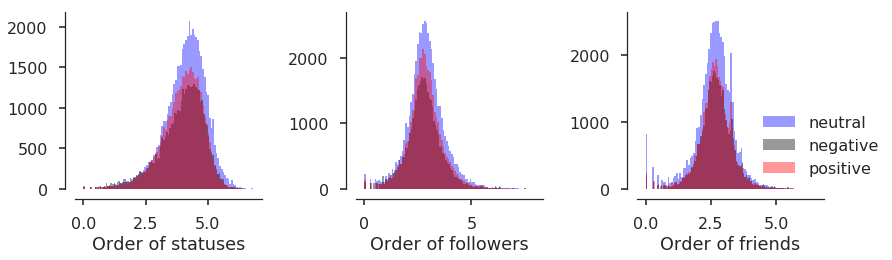

In [27]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
val_cols = ["u_statuses", "u_followers", "u_friends"]
x_labels = ["statuses", "followers", "friends"]

for i, feature in enumerate(val_cols):
    for label, color in zip(["neutral", "negative", "positive",],
                            ["g", "r", "k"]
                           ):
        sns.distplot(df[df.label==label].assign(**{
            feature: lambda x: np.log10(x[feature]+1)
        })[feature], bins=100, kde=False, label=label,
                     #color=color,
                     ax=ax[i])
        ax[i].set_xlabel("Order of %s" % x_labels[i])
        
    plt.legend(bbox_to_anchor=(0.6, 0.5))
#plt.xlim([-2,3])
sns.despine(offset=10)
fig.tight_layout()

/homed/content/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


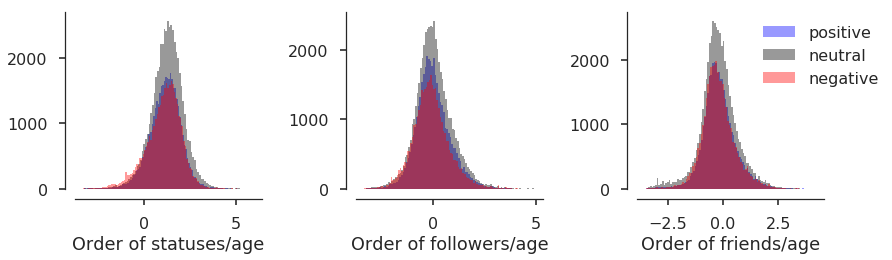

In [28]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
val_cols = ["u_statuses", "u_followers", "u_friends"]
x_labels = ["statuses", "followers", "friends"]

for i, feature in enumerate(val_cols):
    for label, color in zip(label_order,
                            color_order
                           ):
        idx = df.label==label
        sns.distplot(df[idx].assign(**{
            feature: lambda x: np.log10((x[feature] + 1)/(df[idx].user_age + 1))
        })[feature], bins=100, kde=False, label=label,
                     #color=color,
                     ax=ax[i])
        ax[i].set_xlabel("Order of %s/age" % x_labels[i])
        
    plt.legend(bbox_to_anchor=(0.6, 0.5))
#plt.xlim([-2,3])
sns.despine(offset=10)
fig.tight_layout()

/homed/content/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


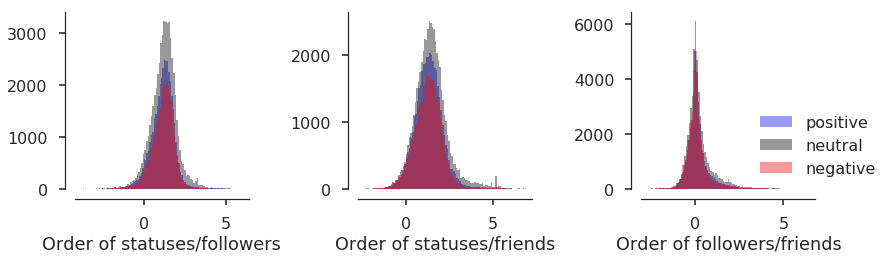

In [29]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
val_cols = ["statuses_followers", "statuses_friends", "followers_friends"]
x_labels = ["statuses/followers", "statuses/friends", "followers/friends"]

for i, feature in enumerate(val_cols):
    for label, color in zip(label_order,
                            color_order
                           ):
        idx = df.label==label
        sns.distplot(df[idx].assign(**{
            feature: lambda x: np.log10((x[feature]))
        })[feature], bins=100, kde=False, label=label,
                     #color=color,
                     ax=ax[i])
        ax[i].set_xlabel("Order of %s" % x_labels[i])
        
    plt.legend(bbox_to_anchor=(0.6, 0.5))
#plt.xlim([-2,3])
sns.despine(offset=10)
fig.tight_layout()

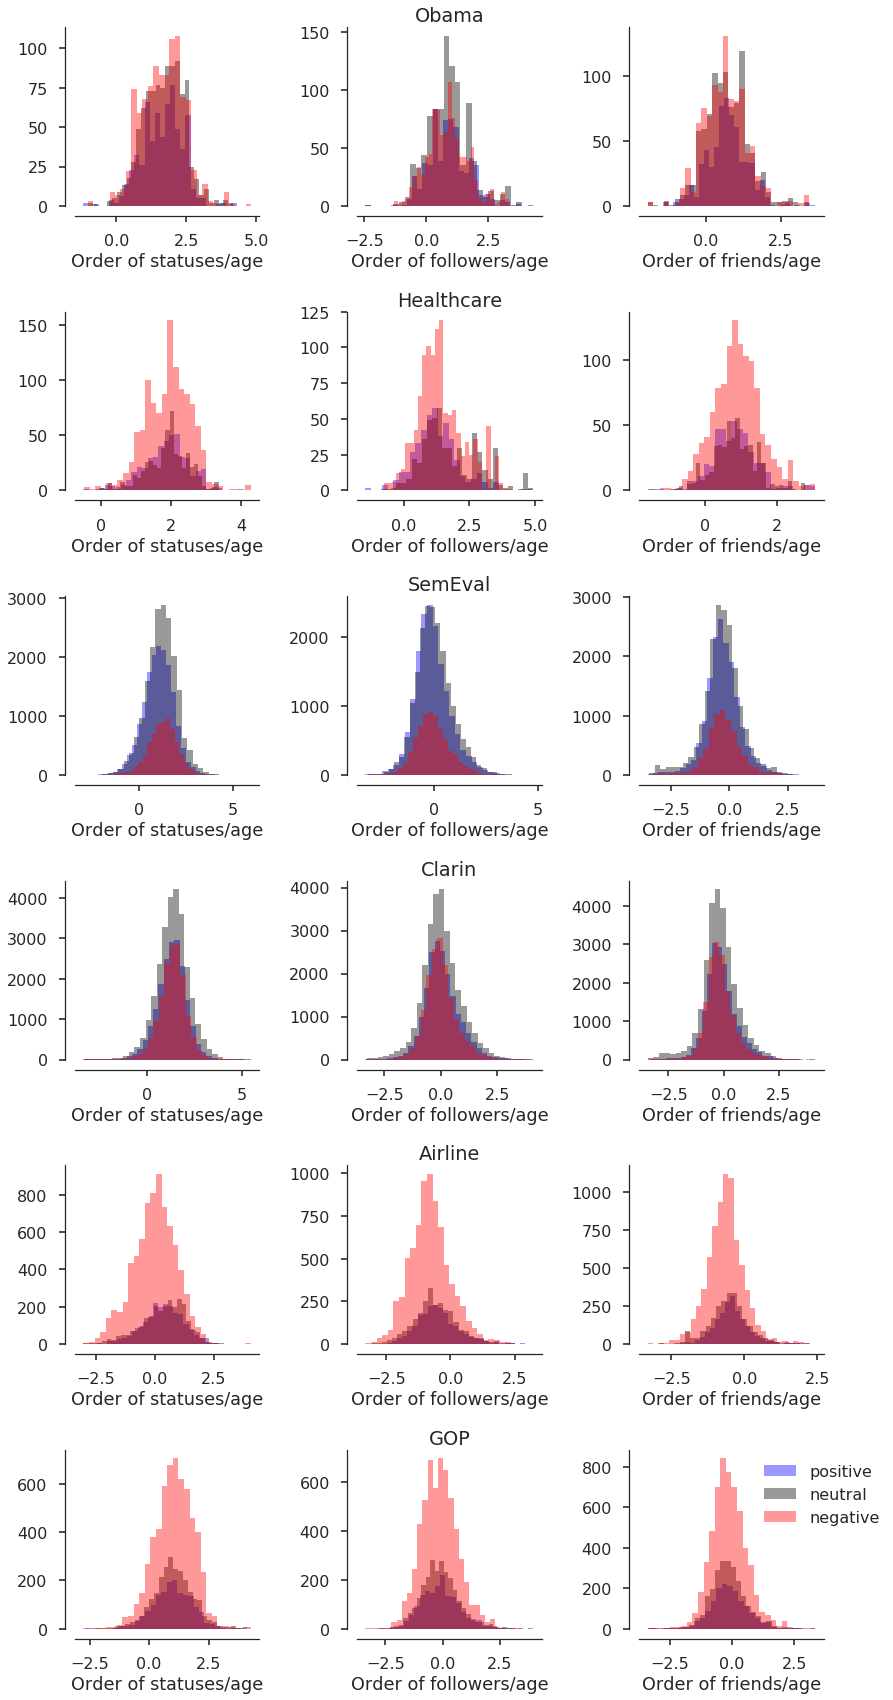

In [30]:
fig, ax = plt.subplots(6,3, figsize=(12,4*6))
val_cols = ["u_statuses", "u_followers", "u_friends"]
x_labels = ["statuses", "followers", "friends"]

for i, dataset in enumerate(df.dataset.unique()):
    for j, feature in enumerate(val_cols):
        for label, color in zip(label_order,
                            color_order
                               ):
            idx = (df.label==label) & (df.dataset==dataset)
            sns.distplot(df[idx].assign(**{
                feature: lambda x: np.log10((x[feature] + 1)/(df[idx].user_age + 1))
            })[feature], bins=30, kde=False, label=label,
                         #color=color,
                         ax=ax[i,j])
            ax[i,j].set_xlabel("Order of %s/age" % x_labels[j])
        if j == 1:
            ax[i,j].set_title(dataset)
        
plt.legend(bbox_to_anchor=(0.6, 0.5))
#plt.xlim([-2,3])
sns.despine(offset=10)
fig.tight_layout()

## Study odds ratios

In [31]:
def plot_points(df, x_col, y_col, bins,
                space_ticks=2, ax=None,
                error=False,
                yscale="linear",
                plot_logits = False,
                despine=True,
               **kwargs):
    if ax is None:
        ax = plt.subplot(111)
    df_t = df[[x_col, y_col]].assign(
        y=df[y_col]
    ).copy()
    df_t["x"], bins = x=pd.cut(df[x_col], bins=bins, retbins=True)
    bins = (bins[1:] + bins[:-1])/2.
    y = df_t.groupby("x")["y"].agg([np.mean, len])
    ref_bin = y[~y["mean"].isnull()].index
    ref_bin = ref_bin[len(ref_bin)//2]
    ref_bin = np.where(y.index.values == ref_bin)[0][0]
    ref_vals = y.iloc[ref_bin]
    
    #x = np.arange(y.shape[0])
    x = bins
    if plot_logits:
        y_vals = np.log((y["mean"]/(1-y["mean"]))
                              /(ref_vals["mean"]/(1-ref_vals["mean"])))
        if error:
            y_err = 1.96*np.sqrt(
                (1./(y["mean"]*y["len"]))
                + (1./((1-y["mean"])*y["len"]))
                + (1./(ref_vals["mean"]*ref_vals["len"]))
                + (1./((1-ref_vals["mean"])*ref_vals["len"]))
                                )
            ax.errorbar(x, y_vals, yerr=y_err, **kwargs)
        else:
            ax.plot(x, y_vals, **kwargs)
        ax.axhline(y=0., linestyle="--", lw=1, color="0.5")
        ax.axvline(x=x[ref_bin], linestyle="--", lw=1, color="0.5")
    else:
        y_vals = y["mean"]
        if error:
            y_err = np.sqrt(y["mean"] * (1 - y["mean"])/y["len"])
            ax.errorbar(x, y_vals, yerr=y_err, **kwargs)
        else:
            ax.plot(x, y_vals, **kwargs)
    #tick_idx = np.arange(0, x.max() + 1, space_ticks)
    #plt.sca(ax)
    #plt.xticks(tick_idx, y.index.values[tick_idx], rotation="vertical")
    ax.set_yscale(yscale)
    if despine:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_position(('outward', 10))
    return ax


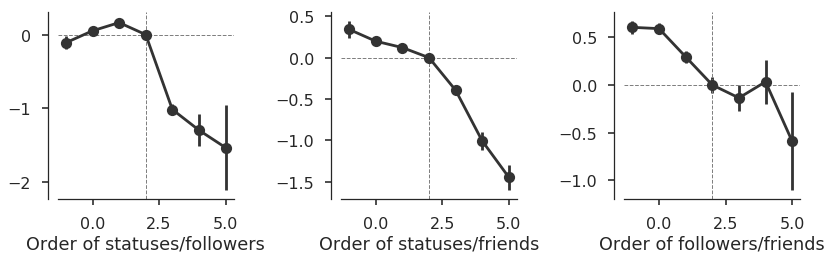

In [32]:
df_t = (df.created_at - df.u_created_at).dt.round("D").apply(lambda x: (x.days + 1))

fig, ax = plt.subplots(1,3, #sharex="col",
                       figsize=(12,4))

val_cols = ["statuses_followers", "statuses_friends", "followers_friends",]
x_labels = ["statuses/followers", "statuses/friends", "followers/friends",]

for j, feature in enumerate(val_cols):
    plot_points(df.assign(**{
            feature: lambda x: np.log10((x[feature])),
            "opinionated": lambda x: (x["opinionated"])* 1.
        }), feature, "opinionated", np.arange(-1.5,6.5,1), space_ticks=1, 
                error=True,
                plot_logits=True,
                color="0.2",
                #label=label,
                marker="o",
                ax=ax[j],
                yscale="linear")
    ax[j].set_xlabel("Order of %s" % x_labels[j])
#ax[1].set_title("Log odds of tweet being opinionated")
#plt.legend(bbox_to_anchor=(1.0, 0.6))
#plt.xlim([-2,3])
#sns.despine(offset=10)
fig.tight_layout()    


/homed/content/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in log
/homed/content/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:2969: RuntimeWarning: invalid value encountered in double_scalars
  high = [thisx + thiserr for (thisx, thiserr)
/homed/content/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:2967: RuntimeWarning: invalid value encountered in double_scalars
  low = [thisx - thiserr for (thisx, thiserr)


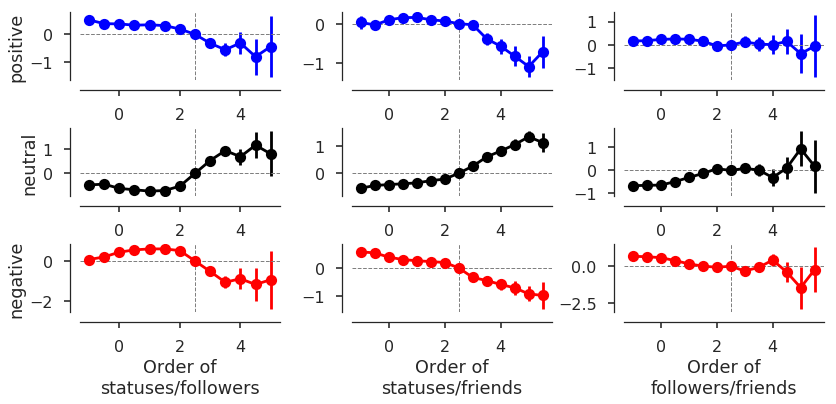

In [33]:
fig, ax = plt.subplots(3,3, sharex="col",
                       figsize=(12,6))

val_cols = ["statuses_followers", "statuses_friends", "followers_friends",]
x_labels = ["statuses/followers", "statuses/friends", "followers/friends",]

for i, (label, color) in enumerate(
    zip(
        label_order,
        color_order
    )
):
    for j, feature in enumerate(val_cols):
        plot_points(df.assign(**{
                feature: lambda x: np.log10((x[feature])),
                "label": lambda x: (x["label"] == label)* 1.
            }), feature, "label", np.arange(-1.25,6.25,0.5), space_ticks=1,
                    error=True,
                    plot_logits=True,
                    color=color,
                    label=label, marker="o",
                    ax=ax[i, j],
                    yscale="linear",
                    despine=False
                   )
        if i == 2:
            ax[i, j].set_xlabel("Order of\n%s" % x_labels[j])
        if j == 0:
            ax[i, j].set_ylabel(label.lower())
#plt.legend(bbox_to_anchor=(1.0, 0.6))
#plt.xlim([-2,3])
sns.despine(offset=10)
fig.tight_layout(h_pad=0, w_pad=0.01)
plt.savefig("figures/Ratio_odds_ratio.pdf", bbox_inches="tight")

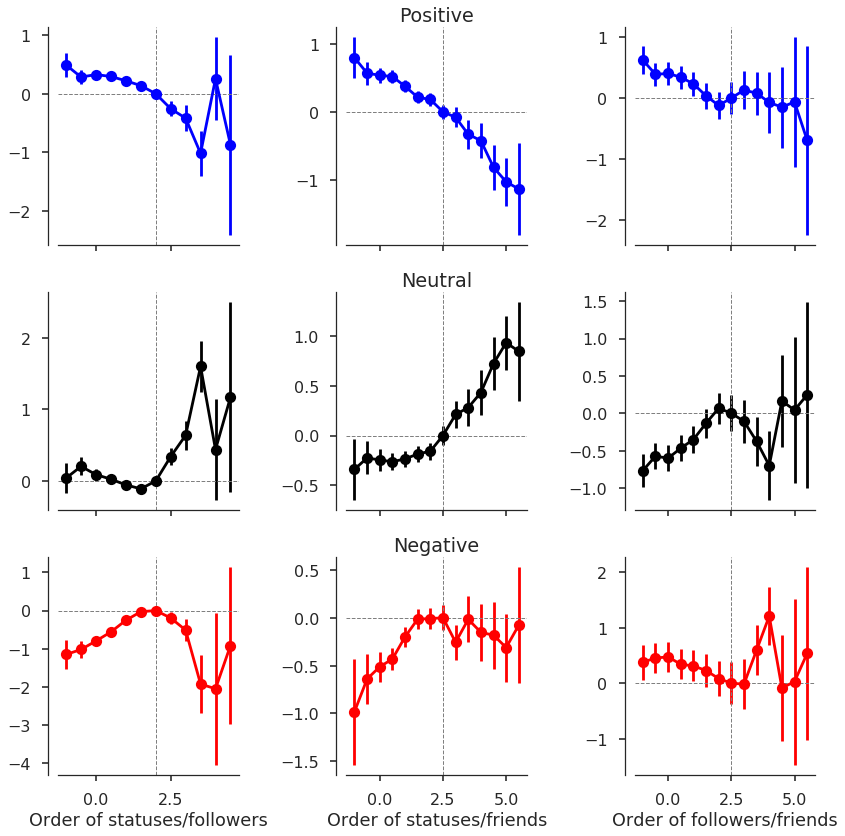

In [34]:
fig, ax = plt.subplots(3,3, sharex="col",
                       figsize=(12,12))

val_cols = ["statuses_followers", "statuses_friends", "followers_friends",]
x_labels = ["statuses/followers", "statuses/friends", "followers/friends",]

dataset="SemEval"
for i, (label, color) in enumerate(zip(label_order,
                            color_order)):
    for j, feature in enumerate(val_cols):
        plot_points(df[df.dataset == dataset].assign(**{
                feature: lambda x: np.log10((x[feature])),
                "label": lambda x: (x["label"] == label)* 1.
            }), feature, "label", np.arange(-1.25,6.25,0.5), space_ticks=1,
                    error=True,
                    plot_logits=True,
                    color=color,
                    label=label, marker="o",
                    ax=ax[i, j],
                    yscale="linear")
        if i == 2:
            ax[i, j].set_xlabel("Order of %s" % x_labels[j])
        if j == 1:
            ax[i, j].set_title(label.title())
#plt.legend(bbox_to_anchor=(1.0, 0.6))
#plt.xlim([-2,3])
#sns.despine(offset=10)
fig.tight_layout()    

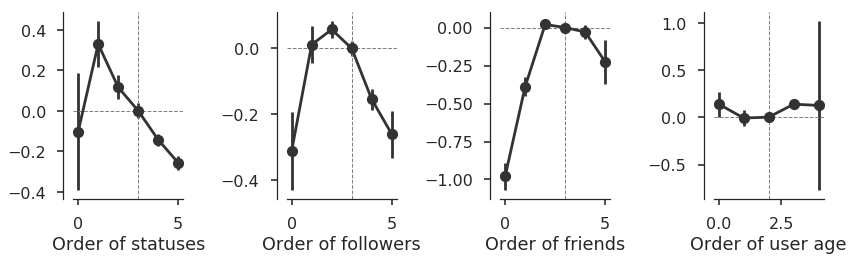

In [35]:
fig, ax = plt.subplots(1,4, #sharex="col",
                       figsize=(12,4))

val_cols = ["u_statuses", "u_followers", "u_friends", "user_age"]
x_labels = ["statuses", "followers", "friends", "user age"]

for j, feature in enumerate(val_cols):    
    plot_points(df.assign(**{
            feature: lambda x: np.log10((x[feature]+1)),
            "opinionated": lambda x: (x["opinionated"])* 1.
        }), feature, "opinionated", np.arange(-0.5,6.5,1), space_ticks=1, 
                error=True,
                plot_logits=True,
                color="0.2",
                #label=label,
                marker="o",
                ax=ax[j],
                yscale="linear")
    ax[j].set_xlabel("Order of %s" % x_labels[j])
#ax[1].set_title("Log odds of tweet being opinionated")
#plt.legend(bbox_to_anchor=(1.0, 0.6))
#plt.xlim([-2,3])
#sns.despine(offset=10)
fig.tight_layout()    

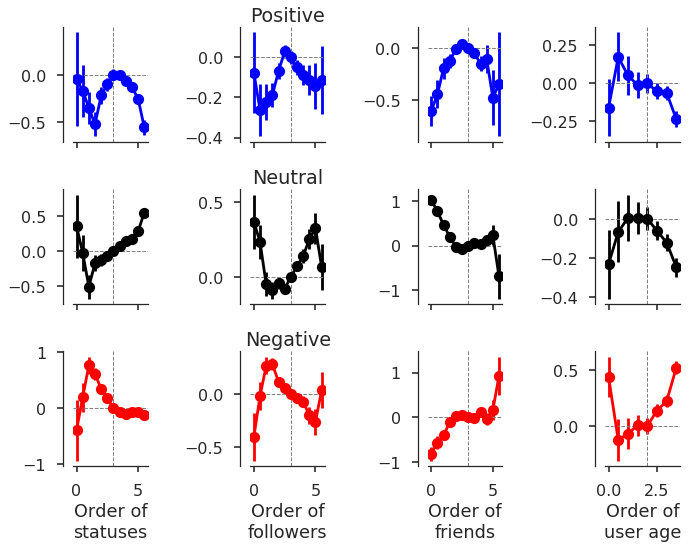

In [36]:
fig, ax = plt.subplots(3,4, sharex="col",
                       figsize=(10,8))

val_cols = ["u_statuses", "u_followers", "u_friends", "user_age"]
x_labels = ["statuses", "followers", "friends", "user age"]

for i, (label, color) in enumerate(
    zip(
        label_order,
        color_order
    )
):
    for j, feature in enumerate(val_cols):
        plot_points(df.assign(**{
                feature: lambda x: np.log10((x[feature] + 1)),
                "label": lambda x: (x["label"] == label)* 1.
            }), feature, "label", np.arange(-0.25,6.25,0.5), space_ticks=1,
                    error=True,
                    plot_logits=True,
                    color=color,
                    label=label, marker="o",
                    ax=ax[i, j],
                    yscale="linear")
        if i == 2:
            ax[i, j].set_xlabel("Order of\n%s" % x_labels[j])
        if j == 1:
            ax[i, j].set_title(label.title())
#plt.legend(bbox_to_anchor=(1.0, 0.6))
#plt.xlim([-2,3])
#sns.despine(offset=10)
fig.tight_layout()    

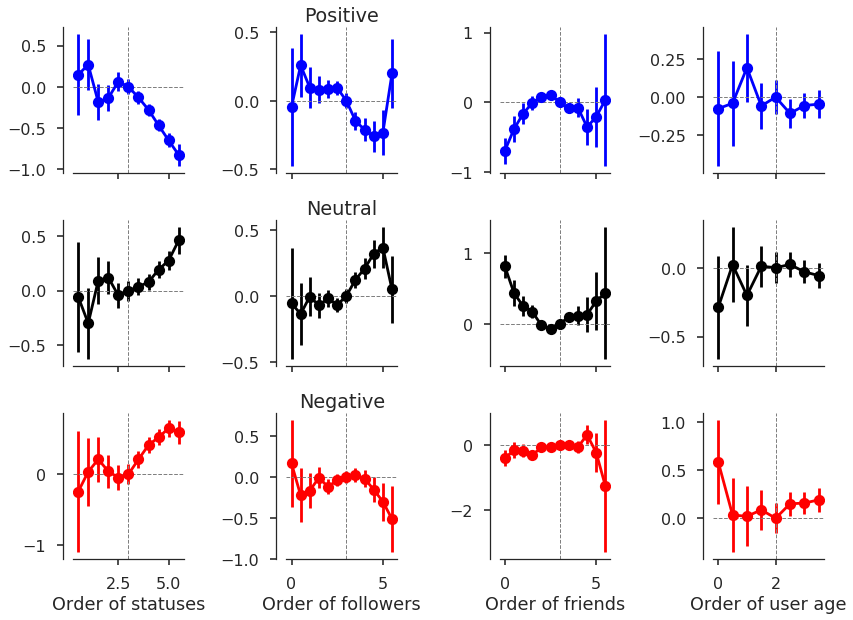

In [37]:
fig, ax = plt.subplots(3,4, sharex="col",
                       figsize=(12,9))

val_cols = ["u_statuses", "u_followers", "u_friends", "user_age"]
x_labels = ["statuses", "followers", "friends", "user age"]

dataset="SemEval"
for i, (label, color) in enumerate(
    zip(
        label_order,
        color_order
    )
):
    for j, feature in enumerate(val_cols):
        plot_points(df[df.dataset == dataset].assign(**{
                feature: lambda x: np.log10((x[feature] + 1)),
                "label": lambda x: (x["label"] == label)* 1.
            }), feature, "label", np.arange(-0.25,6.25,0.5), space_ticks=1,
                    error=True,
                    plot_logits=True,
                    color=color,
                    label=label, marker="o",
                    ax=ax[i, j],
                    yscale="linear")
        if i == 2:
            ax[i, j].set_xlabel("Order of %s" % x_labels[j])
        if j == 1:
            ax[i, j].set_title(label.title())
#plt.legend(bbox_to_anchor=(1.0, 0.6))
#plt.xlim([-2,3])
#sns.despine(offset=10)
fig.tight_layout()    

/homed/content/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in log
/homed/content/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:2969: RuntimeWarning: invalid value encountered in double_scalars
  high = [thisx + thiserr for (thisx, thiserr)
/homed/content/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:2967: RuntimeWarning: invalid value encountered in double_scalars
  low = [thisx - thiserr for (thisx, thiserr)


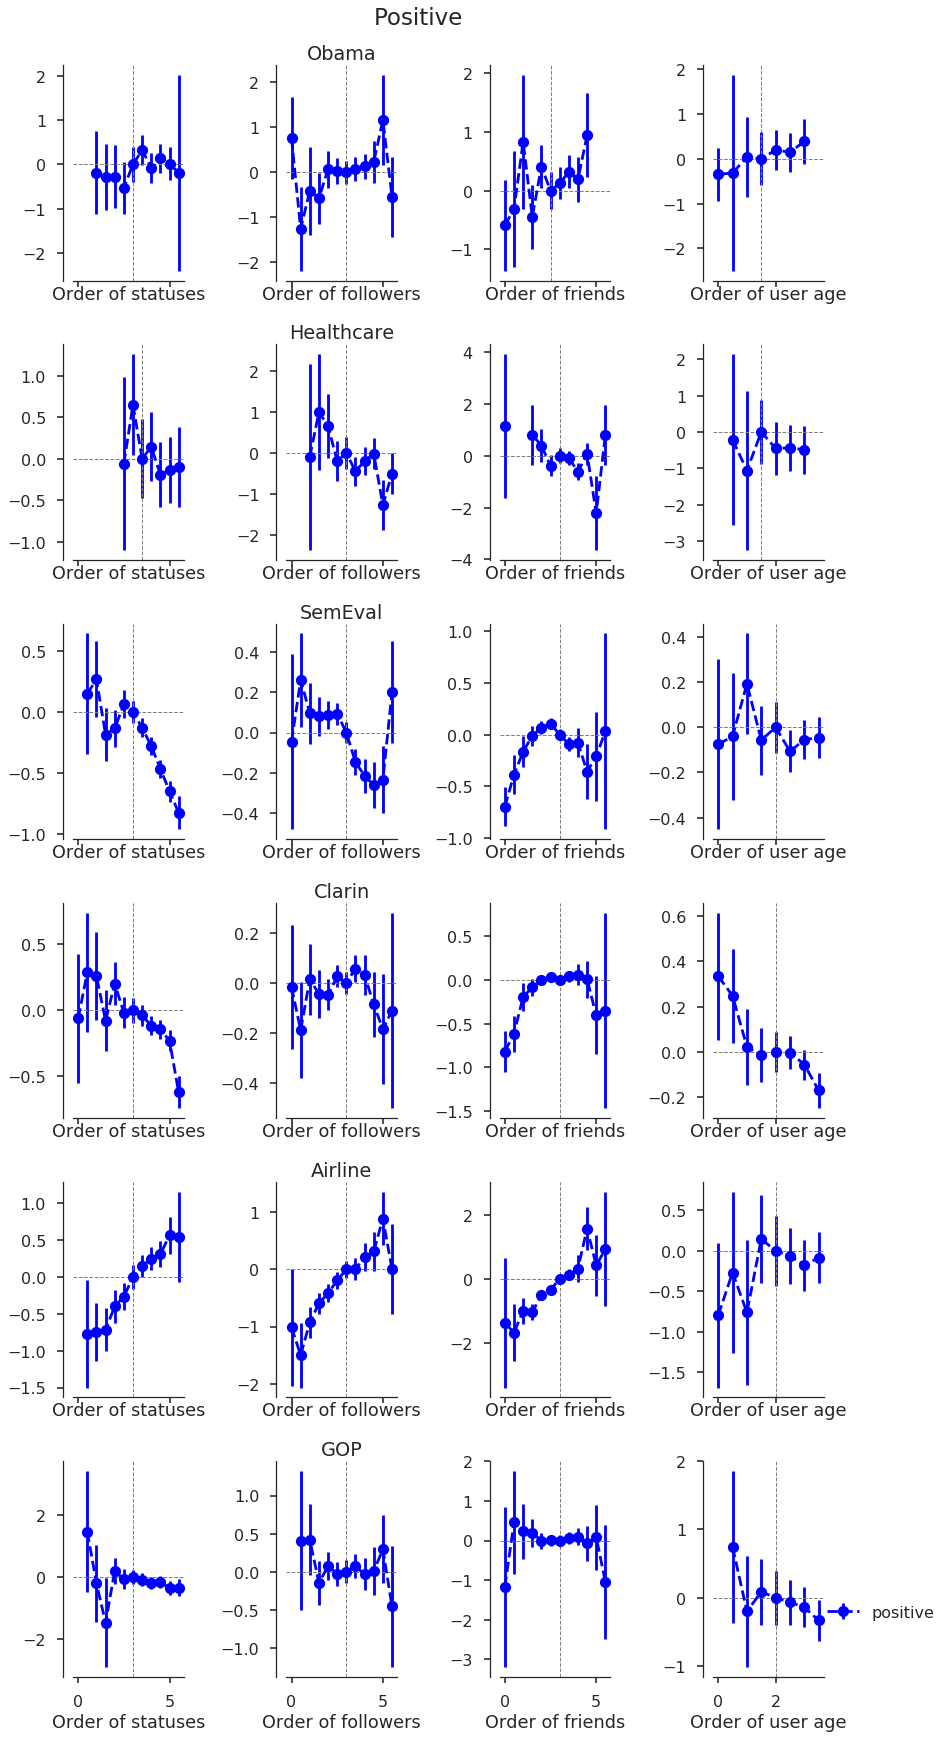

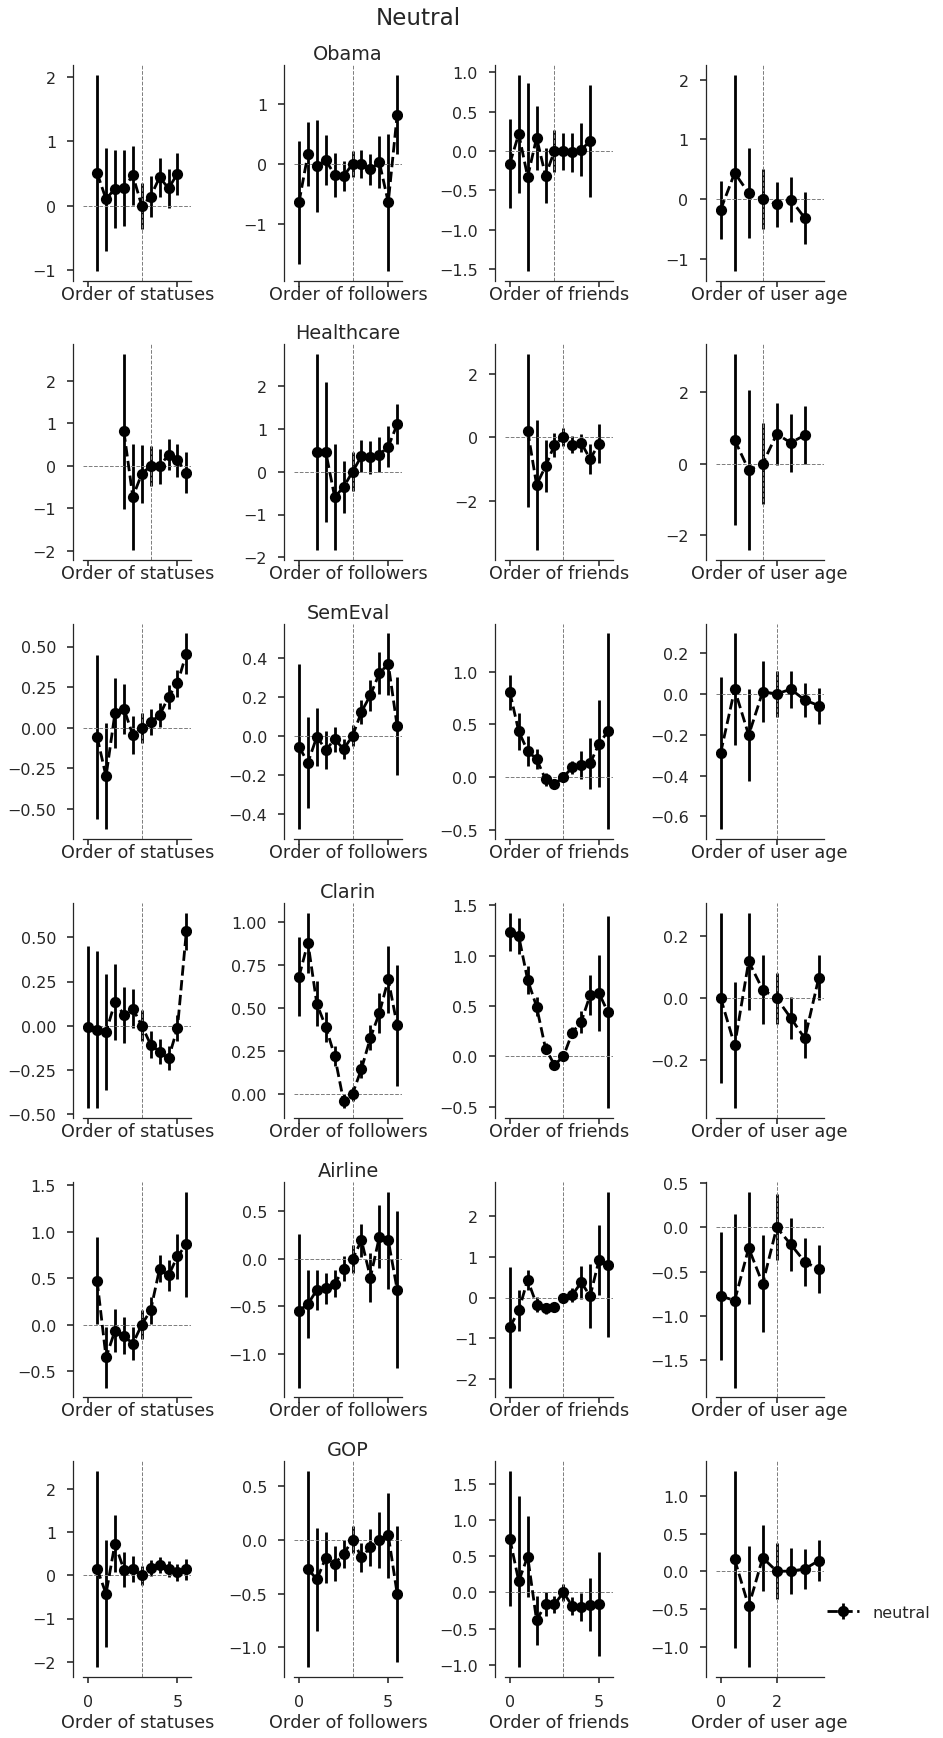

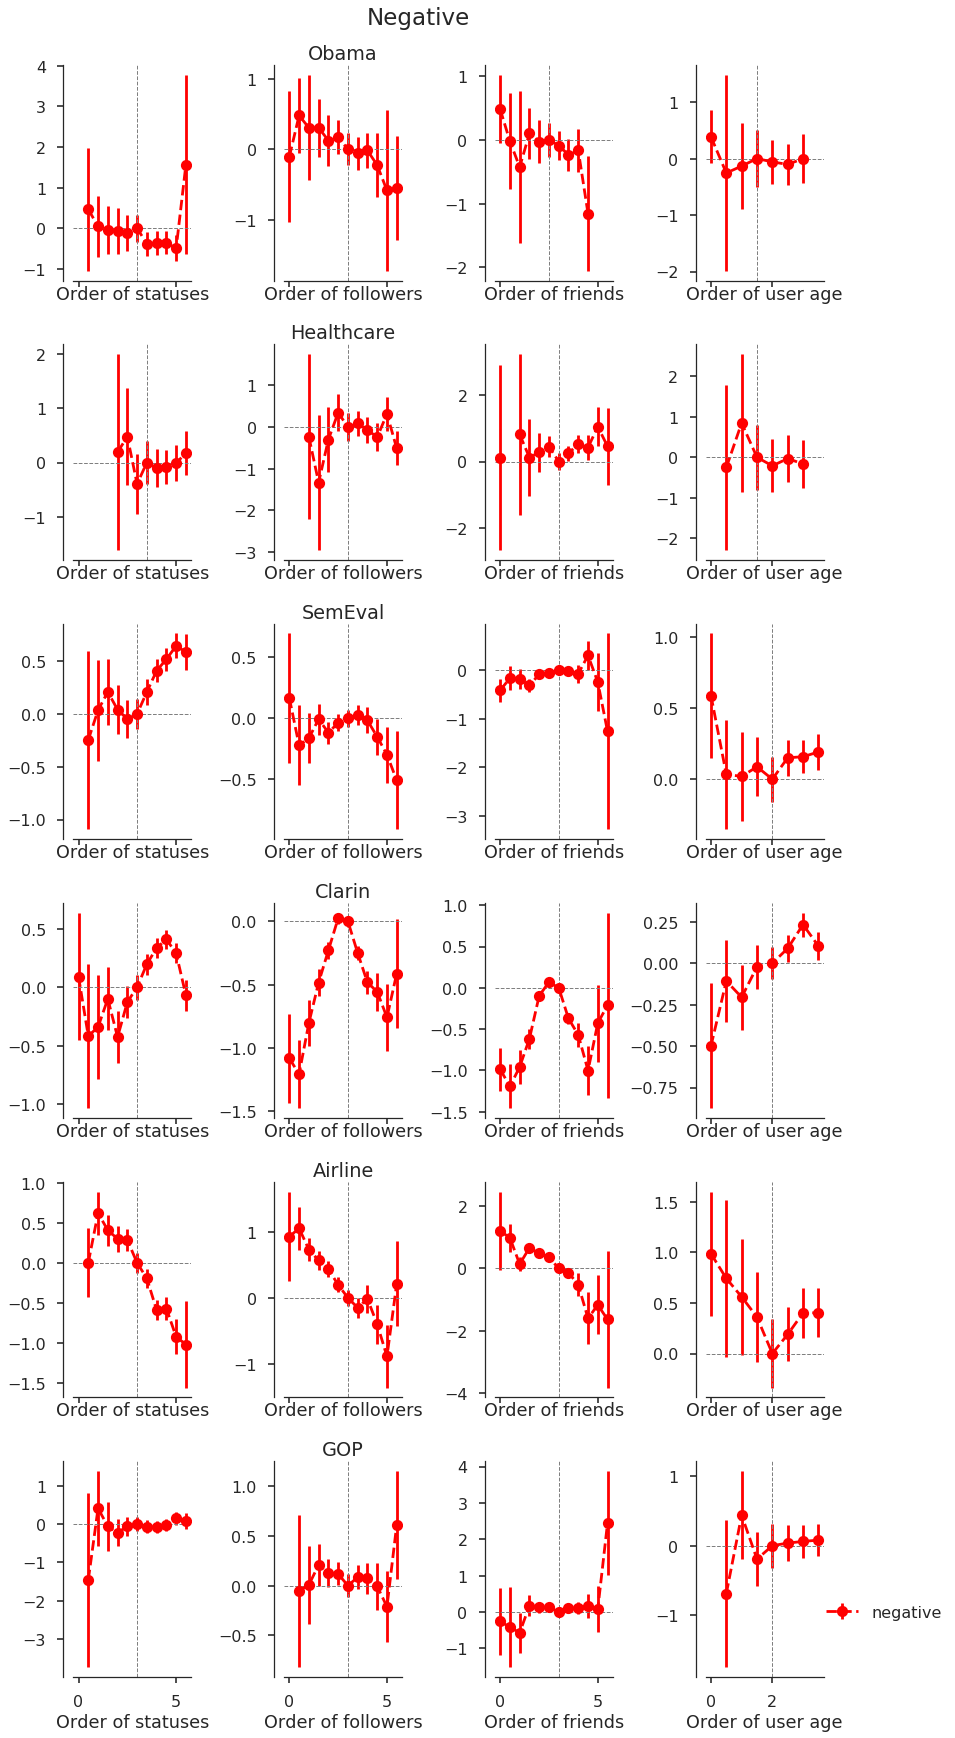

In [38]:
val_cols = ["u_statuses", "u_followers", "u_friends", "user_age"]
x_labels = ["statuses", "followers", "friends", "user age"]

for label, color in zip(label_order,
                            color_order):
    fig, ax = plt.subplots(6,4, sharex="col",
                       figsize=(12,4*6))
    for i, dataset in enumerate(df.dataset.unique()):
        idx = (df.dataset==dataset)
        for j, feature in enumerate(val_cols):
            df_X = df[idx].assign(**{
                feature: lambda x: np.log10((x[feature]+1)),
                "label": lambda x: (x["label"] == label)* 1.
            })
            plot_points(df_X, feature, "label", np.arange(-0.25,6.25,0.5),
                        space_ticks=1,
                        error=True,
                        plot_logits=True,
                        color=color,
                        label=label, marker="o",
                        ax=ax[i, j],
                        yscale="linear",
                        linestyle="--", 
                       )
            ax[i,j].set_xlabel("Order of %s" % x_labels[j])
            #plt.sca(ax[i,j])
            #plt.xticks(rotation=45)
            #tick_labels = range(0,int(ax[i,j].get_xlim()[1]),2)
            #plt.xticks(tick_labels, tick_labels)
            if j == 1:
                ax[i,j].set_title(dataset)
       
    plt.legend(bbox_to_anchor=(0.9, 0.4))
    #plt.xlim([-2,3])
    #sns.despine(offset=10)
    fig.suptitle(label.title(), y=1.01)
    fig.tight_layout()

### Tweet features

/homed/content/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:2967: RuntimeWarning: invalid value encountered in double_scalars
  low = [thisx - thiserr for (thisx, thiserr)


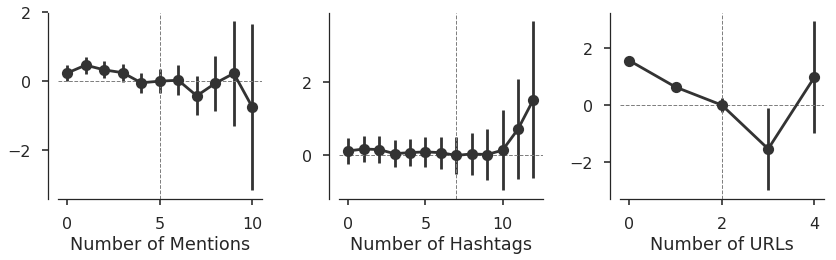

In [39]:
fig, ax = plt.subplots(1,3, #sharex="col",
                       figsize=(12,4))

val_cols = ["n_mentions", "n_hashtags", "n_urls", ]
x_labels = ["Mentions", "Hashtags", "URLs"]
bins = [np.arange(-0.5, 11, 1),
        np.arange(-0.5, 15, 1), 
        np.arange(-0.5, 5, 1), 
       ]

for j, feature in enumerate(val_cols):   
    plot_points(df.assign(**{
            "opinionated": lambda x: (x["opinionated"])* 1.
        }), feature, "opinionated", bins[j], space_ticks=1, 
                error=True,
                plot_logits=True,
                color="0.2",
                #label=label,
                marker="o",
                ax=ax[j],
                yscale="linear")
    ax[j].set_xlabel("Number of %s" % x_labels[j])
#ax[1].set_title("Log odds of tweet being opinionated")
#plt.legend(bbox_to_anchor=(1.0, 0.6))
#plt.xlim([-2,3])
#sns.despine(offset=10)
fig.tight_layout()

/homed/content/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:2967: RuntimeWarning: invalid value encountered in double_scalars
  low = [thisx - thiserr for (thisx, thiserr)
/homed/content/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in log
/homed/content/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:2969: RuntimeWarning: invalid value encountered in double_scalars
  high = [thisx + thiserr for (thisx, thiserr)


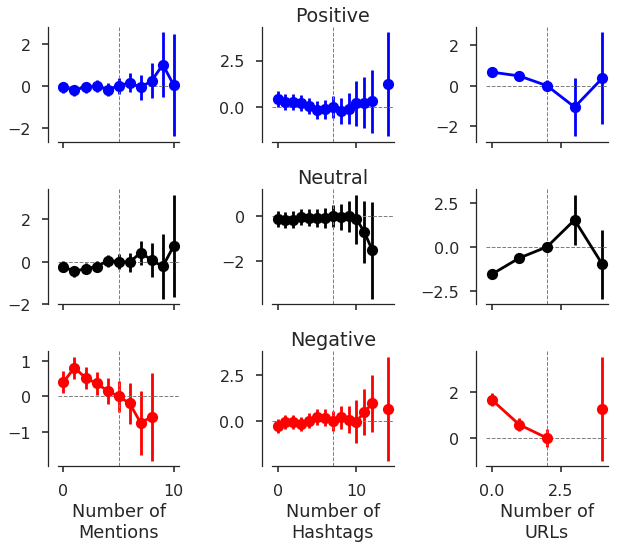

In [40]:
fig, ax = plt.subplots(3,3, sharex="col",
                       figsize=(9,8))

val_cols = ["n_mentions", "n_hashtags", "n_urls", ]
x_labels = ["Mentions", "Hashtags", "URLs"]
bins = [np.arange(-0.5, 11, 1),
        np.arange(-0.5, 15, 1), 
        np.arange(-0.5, 5, 1), 
       ]


for i, (label, color) in enumerate(
    zip(
        label_order,
        color_order
    )
):
    for j, feature in enumerate(val_cols):
        plot_points(df.assign(**{
                "label": lambda x: (x["label"] == label)* 1.
            }), feature, "label", bins[j], space_ticks=1,
                    error=True,
                    plot_logits=True,
                    color=color,
                    label=label, marker="o",
                    ax=ax[i, j],
                    yscale="linear")
        if i == 2:
            ax[i, j].set_xlabel("Number of\n%s" % x_labels[j])
        if j == 1:
            ax[i, j].set_title(label.title())
#plt.legend(bbox_to_anchor=(1.0, 0.6))
#plt.xlim([-2,3])
#sns.despine(offset=10)
fig.tight_layout()    

/homed/content/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:2967: RuntimeWarning: invalid value encountered in double_scalars
  low = [thisx - thiserr for (thisx, thiserr)
/homed/content/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in log
/homed/content/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:2969: RuntimeWarning: invalid value encountered in double_scalars
  high = [thisx + thiserr for (thisx, thiserr)


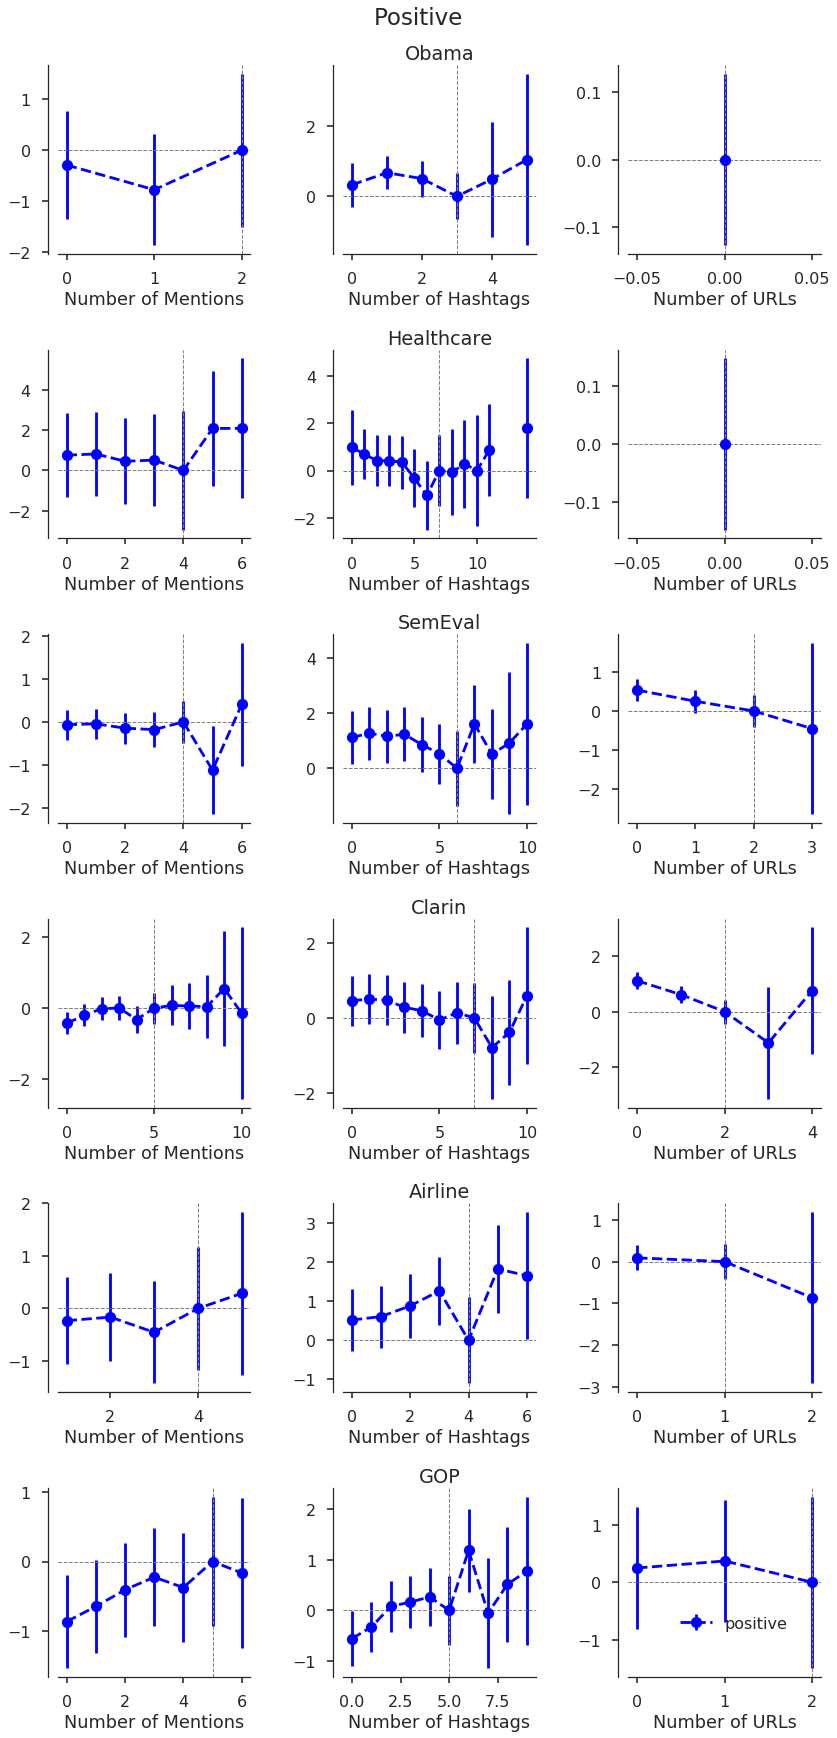

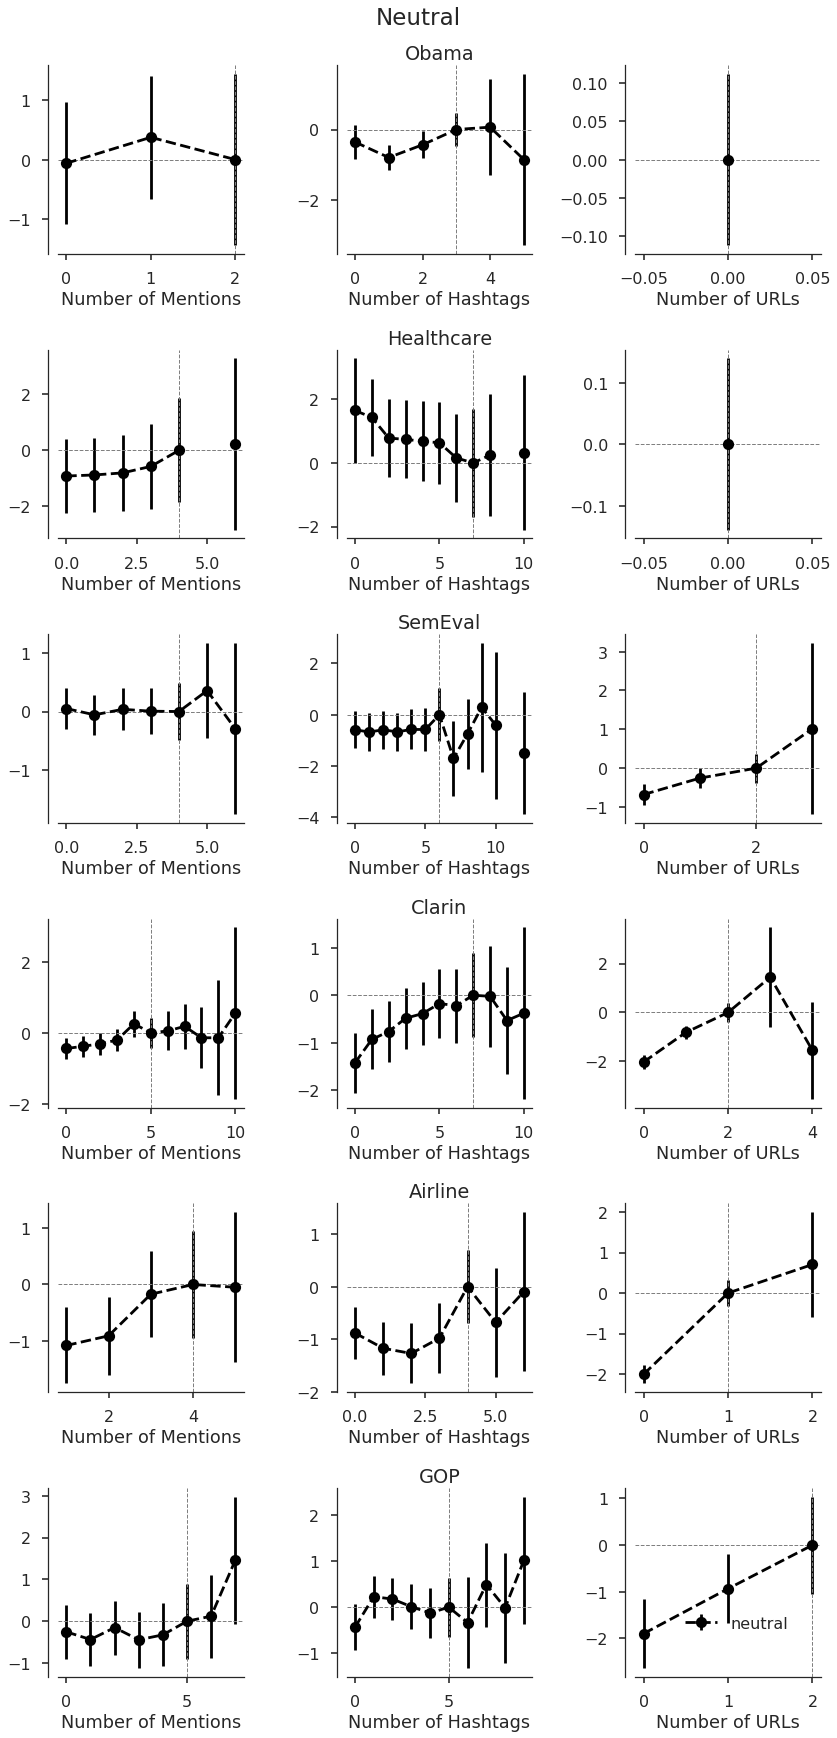

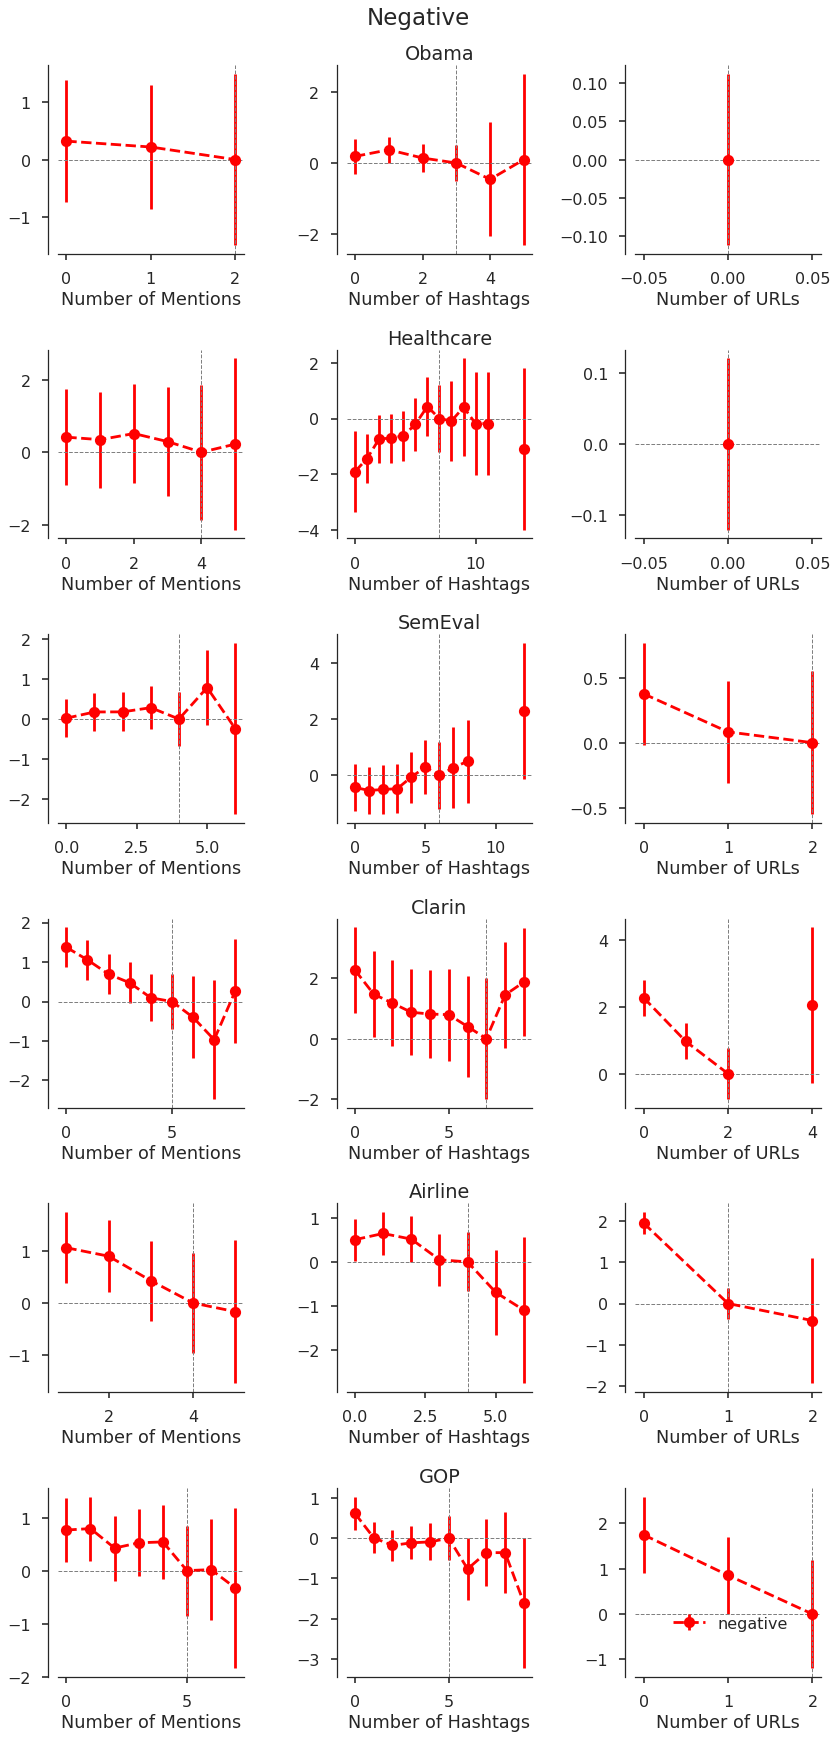

In [41]:
val_cols = ["n_mentions", "n_hashtags", "n_urls", ]
x_labels = ["Mentions", "Hashtags", "URLs"]
bins = [np.arange(-0.5, 11, 1),
        np.arange(-0.5, 15, 1), 
        np.arange(-0.5, 5, 1), 
       ]


for label, color in zip(label_order,
                            color_order):
    fig, ax = plt.subplots(6,3, figsize=(12,4*6))
    for i, dataset in enumerate(df.dataset.unique()):
        idx = (df.dataset==dataset)
        for j, feature in enumerate(val_cols):
            df_X = df[idx].assign(**{
                "label": lambda x: (x["label"] == label)* 1.
            })
            plot_points(df_X, feature, "label", bins[j],
                        space_ticks=1,
                        error=True,
                        plot_logits=True,
                        color=color,
                        label=label, marker="o",
                        ax=ax[i, j],
                        yscale="linear",
                        linestyle="--", 
                       )
            ax[i,j].set_xlabel("Number of %s" % x_labels[j])
            #plt.sca(ax[i,j])
            #plt.xticks(rotation=45)
            #tick_labels = range(0,int(ax[i,j].get_xlim()[1]),2)
            #plt.xticks(tick_labels, tick_labels)
            if j == 1:
                ax[i,j].set_title(dataset)
        
    plt.legend(bbox_to_anchor=(0.9, 0.4))
    #plt.xlim([-2,3])
    #sns.despine(offset=10)
    fig.suptitle(label.title(), y=1.01)
    fig.tight_layout()

## Relation of opinionated with features

In [42]:
def get_nearest_bin(x, bins):
    x = np.asarray(x)
    bins = np.array([x.min() - 1] + list(bins) + [int(x.max()) + 1])
    idx = np.digitize(x, bins)
    bins = (bins[:-1] + bins[1:])/2.
    return bins[idx-1]
get_nearest_bin([1.5, 0.3, 10], bins=[0, 1, 2])

array([ 1.5,  0.5,  6.5])

## Fit models

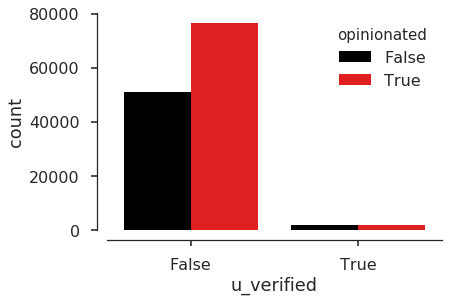

In [43]:
with sns.color_palette(["#000000", "#FF0000", "#00FF00", "#0000FF"]):
    sns.countplot(x="u_verified", hue="opinionated", data=df)
    sns.despine(offset=10)

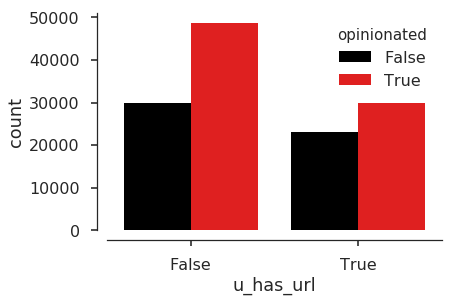

In [44]:
with sns.color_palette(["#000000", "#FF0000", "#00FF00", "#0000FF"]):
    sns.countplot(x="u_has_url", hue="opinionated", data=df)
    sns.despine(offset=10)

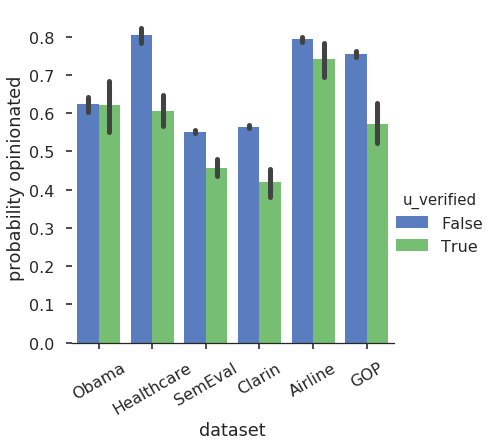

In [45]:
g = sns.factorplot(x="dataset", y="opinionated", hue="u_verified", data=df,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("probability opinionated")
g.set_xticklabels(rotation=30)

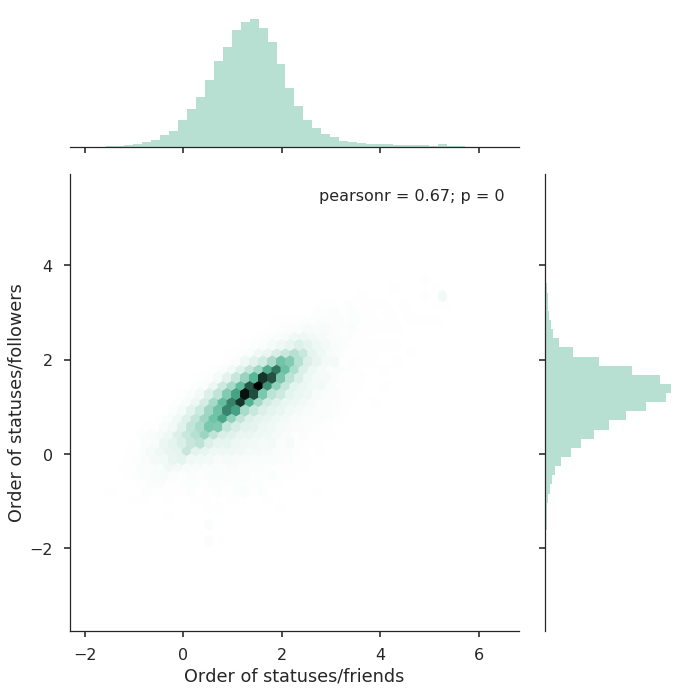

In [46]:
sns.jointplot(x="statuses_friends", y="statuses_followers",
              data=df.assign(**{
        "statuses_friends": lambda x: np.log10(x["statuses_friends"]),
        "statuses_followers": lambda x: np.log10(x["statuses_followers"]),
        }
    ),
              kind="hex", color="#4CB391", ratio=3, size=10).set_axis_labels(
        "Order of statuses/friends", "Order of statuses/followers")

## Model the data

In [47]:
df[df.label != "neutral"][
    ["statuses_followers", "statuses_friends", "followers_friends"]
].assign(**{
        "statuses_followers": lambda x: np.log10(x["statuses_followers"]),
        "statuses_friends": lambda x: np.log10(x["statuses_friends"]),
        "followers_friends": lambda x: np.log10(x["followers_friends"]),
}).describe()

,statuses_followers,statuses_friends,followers_friends
count,78630.000000,78630.000000,78630.000000
mean,1.153524,1.284498,0.130974
std,0.666646,0.800580,0.606765
min,-3.740527,-2.300252,-2.574610
25%,0.774240,0.784990,-0.187990
50%,1.223313,1.291520,0.045293
75%,1.587685,1.766808,0.298559
max,5.123123,6.813617,6.364583


In [48]:
df.ix[df.u_statuses > 1000000, ["tid", "u_statuses", "label",]].head()

/homed/content/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  if __name__ == '__main__':


,tid,u_statuses,label
2753,9936649534,1151779,neutral
2927,10074783718,1063031,negative
3221,10616430498,1063031,neutral
3274,10666695978,1063031,neutral
3520,10718081976,1063031,neutral


In [49]:
df.ix[df.statuses_followers > 100000,
      ["tid", "u_statuses", "u_followers", u'statuses_followers', "label",]].head()

,tid,u_statuses,u_followers,statuses_followers,label
17717,511418696766476288,581583,0,581584.000000,neutral
22686,511690173059702784,372265,1,186133.000000,neutral
24329,511766324842741760,530051,4,106010.400000,neutral
25270,511857668416225281,469756,2,156585.666667,neutral
31148,512164708259221505,485126,2,161709.000000,neutral


In [50]:
df.assign(**{
            "u_statuses": lambda x: np.log10(x["u_statuses"] + 1),
            "u_followers": lambda x: np.log10(x["u_followers"] + 1),
            "u_friends": lambda x: np.log10(x["u_friends"] + 1),
            }      
        )[["u_statuses", "u_followers", "u_friends"]].corr()

,u_statuses,u_followers,u_friends
u_statuses,1.000000,0.645971,0.393703
u_followers,0.645971,1.000000,0.642325
u_friends,0.393703,0.642325,1.000000


In [51]:
for dataset in df.dataset.unique():
    print("Dataset: %s" % dataset)
    print(df[df.dataset == dataset].assign(**{
                "u_statuses": lambda x: np.log10(x["u_statuses"] + 1),
                "u_followers": lambda x: np.log10(x["u_followers"] + 1),
                "u_friends": lambda x: np.log10(x["u_friends"] + 1),
                }      
            )[["u_statuses", "u_followers", "u_friends"]].corr())

Dataset: Obama
             u_statuses  u_followers  u_friends
u_statuses     1.000000     0.817738   0.771271
u_followers    0.817738     1.000000   0.850611
u_friends      0.771271     0.850611   1.000000
Dataset: Healthcare
             u_statuses  u_followers  u_friends
u_statuses     1.000000     0.423966   0.473030
u_followers    0.423966     1.000000   0.504586
u_friends      0.473030     0.504586   1.000000
Dataset: SemEval
             u_statuses  u_followers  u_friends
u_statuses     1.000000     0.596546   0.315546
u_followers    0.596546     1.000000   0.531897
u_friends      0.315546     0.531897   1.000000
Dataset: Clarin
             u_statuses  u_followers  u_friends
u_statuses     1.000000     0.625756   0.336565
u_followers    0.625756     1.000000   0.659668
u_friends      0.336565     0.659668   1.000000
Dataset: Airline
             u_statuses  u_followers  u_friends
u_statuses     1.000000     0.792471   0.648891
u_followers    0.792471     1.000000   0.767157
u_f

In [52]:
for label in ["neutral", "negative", "positive"]:
    print(label)
    print(df[df.label == label].assign(**{
                "u_statuses": lambda x: np.log10(x["u_statuses"] + 1),
                "u_followers": lambda x: np.log10(x["u_followers"] + 1),
                "u_friends": lambda x: np.log10(x["u_friends"] + 1),
                }      
            )[["u_statuses", "u_followers", "u_friends"]].corr())

neutral
             u_statuses  u_followers  u_friends
u_statuses     1.000000     0.588756   0.302572
u_followers    0.588756     1.000000   0.609161
u_friends      0.302572     0.609161   1.000000
negative
             u_statuses  u_followers  u_friends
u_statuses     1.000000     0.726996   0.515023
u_followers    0.726996     1.000000   0.710998
u_friends      0.515023     0.710998   1.000000
positive
             u_statuses  u_followers  u_friends
u_statuses     1.000000     0.642748   0.427479
u_followers    0.642748     1.000000   0.639048
u_friends      0.427479     0.639048   1.000000


In [53]:
for label in ["neutral", "negative", "positive"]:
    print(label)
    print(df[df.label == label][["u_statuses", "u_followers", "u_friends"]].corr("spearman"))

neutral
             u_statuses  u_followers  u_friends
u_statuses     1.000000     0.585336   0.327264
u_followers    0.585336     1.000000   0.644582
u_friends      0.327264     0.644582   1.000000
negative
             u_statuses  u_followers  u_friends
u_statuses     1.000000     0.727441   0.492095
u_followers    0.727441     1.000000   0.724619
u_friends      0.492095     0.724619   1.000000
positive
             u_statuses  u_followers  u_friends
u_statuses     1.000000     0.642546   0.406830
u_followers    0.642546     1.000000   0.658145
u_friends      0.406830     0.658145   1.000000


In [54]:
df_t = df.pivot_table(index="dataset", columns="label", values="u_verified", aggfunc=np.mean)
df_t*100

label,negative,neutral,positive
dataset,,,
Airline,2.271540,3.710938,4.808636
Clarin,0.664493,1.442343,0.938917
GOP,2.433628,5.940594,3.560467
Healthcare,20.276100,40.494297,20.852018
Obama,7.344064,7.731434,8.082409
SemEval,2.972278,5.332028,4.017695


In [55]:
df_t = df.pivot_table(index="dataset", columns="label", values="u_has_url", aggfunc=np.mean)
df_t*100

label,negative,neutral,positive
dataset,,,
Airline,35.130548,42.460938,46.074583
Clarin,28.002758,37.723396,32.568685
GOP,36.980939,45.861386,37.630448
Healthcare,64.710958,71.102662,67.264574
Obama,71.931590,78.738555,80.190174
SemEval,37.825093,49.039205,49.000121


In [56]:
(df.groupby("label")[["u_verified"]].mean()*100).T

label,negative,neutral,positive
u_verified,2.430187,3.696083,2.848141


In [57]:
(df.groupby("label")[["u_has_url"]].mean()*100).T

label,negative,neutral,positive
u_has_url,34.791273,43.579047,41.381811


In [58]:
for label in ["neutral", "negative", "positive"]:
    print(label)
    print(df[df.label == label][["n_urls", "n_hashtags", "n_mentions"]].corr("spearman"))

neutral
              n_urls  n_hashtags  n_mentions
n_urls      1.000000    0.108869   -0.196992
n_hashtags  0.108869    1.000000   -0.007123
n_mentions -0.196992   -0.007123    1.000000
negative
              n_urls  n_hashtags  n_mentions
n_urls      1.000000    0.064662   -0.110559
n_hashtags  0.064662    1.000000   -0.016682
n_mentions -0.110559   -0.016682    1.000000
positive
              n_urls  n_hashtags  n_mentions
n_urls      1.000000    0.062308   -0.162101
n_hashtags  0.062308    1.000000   -0.014810
n_mentions -0.162101   -0.014810    1.000000


In [59]:
df_t = df.pivot_table(index="dataset", columns="label",
                      values=["n_urls", "n_hashtags", "n_mentions"],
                      aggfunc=np.mean)
df_t

n_hashtags                     n_mentions                      \
label        negative   neutral  positive   negative   neutral  positive   
dataset                                                                    
Airline      0.216580  0.217188  0.289500   1.110052  1.165625  1.132483   
Clarin       0.126943  0.379051  0.264284   0.582435  0.762588  0.803148   
GOP          1.414738  1.471287  1.669736   0.888019  0.944158  1.079804   
Healthcare   2.781708  1.975285  2.141256   0.471096  0.507605  0.464126   
Obama        1.200201  1.302136  1.194929   0.156942  0.203459  0.131537   
SemEval      0.303087  0.289166  0.301297   0.400400  0.353820  0.359532   

              n_urls                      
label       negative   neutral  positive  
dataset                                   
Airline     0.009530  0.094922  0.026987  
Clarin      0.069458  0.291398  0.132515  
GOP         0.126787  0.313267  0.199509  
Healthcare  0.000000  0.000000  0.000000  
Obama       0.000000  0.000000  0.000000  
SemEval     0.231209  0.327958  0.242637

In [60]:
df.assign(**{
                "u_statuses": lambda x: np.log10(x["u_statuses"] + 1),
                "u_followers": lambda x: np.log10(x["u_followers"] + 1),
                "u_friends": lambda x: np.log10(x["u_friends"] + 1),
                "user_age": lambda x: np.log10(x["user_age"] + 1),
                }      
            ).pivot_table(index="dataset", columns="label",
                      values=["u_statuses", "u_followers", "u_friends", "user_age"],
                          aggfunc=np.mean)

u_followers                     u_friends                      \
label         negative   neutral  positive  negative   neutral  positive   
dataset                                                                    
Airline       2.296510  2.479561  2.623156  2.438967  2.530303  2.664496   
Clarin        2.811111  2.802076  2.812978  2.655189  2.614812  2.665490   
GOP           2.952083  2.993316  2.963995  2.957585  2.936671  2.956501   
Healthcare    3.978590  4.366995  3.824725  3.469766  3.415646  3.371995   
Obama         3.001318  3.127359  3.161339  2.806798  2.894916  2.970706   
SemEval       2.862439  2.912520  2.823176  2.636849  2.578994  2.607556   

           u_statuses                      user_age                      
label        negative   neutral  positive  negative   neutral  positive  
dataset                                                                  
Airline      3.069085  3.414217  3.436760  3.078444  3.056453  3.079143  
Clarin       4.181052  4.151224  4.075500  2.818997  2.783946  2.769362  
GOP          4.126807  4.113671  4.047071  3.084751  3.097161  3.044418  
Healthcare   4.485996  4.480175  4.443052  2.566696  2.578194  2.566125  
Obama        3.804042  3.916361  3.915894  2.147809  2.203098  2.254961  
SemEval      4.142833  4.068890  3.904331  2.904155  2.885415  2.886646

In [61]:
df_t = df.pivot_table(index="dataset", columns="label", values="is_reply", aggfunc=np.mean)
df_t*100

label,negative,neutral,positive
dataset,,,
Airline,45.365535,50.703125,63.395486
Clarin,17.533852,17.267334,18.479595
GOP,4.254595,3.524752,4.112953
Healthcare,1.380500,0.950570,2.017937
Obama,12.474849,16.683622,9.033281
SemEval,17.905116,14.126011,13.180221


In [62]:
df_t = df.pivot_table(index="dataset", columns="label", values="is_quote", aggfunc=np.mean)
df_t*100

label,negative,neutral,positive
dataset,,,
Airline,0.013055,0.000000,0.000000
Clarin,0.087763,0.163144,0.090691
GOP,4.186521,6.534653,5.709024
Healthcare,0.000000,0.000000,0.000000
Obama,0.000000,0.000000,0.000000
SemEval,5.887396,3.333162,2.636044


In [63]:
(df.groupby("label")[["is_reply"]].mean()*100).T

label,negative,neutral,positive
is_reply,20.484485,16.9042,17.663974


In [64]:
(df.groupby("label")[["is_quote"]].mean()*100).T

label,negative,neutral,positive
is_quote,1.741764,1.615857,1.362807


## Individual dataset details

In [65]:
df.dataset.value_counts()

Clarin        61667
SemEval       42911
Airline       12258
GOP           10030
Obama          2608
Healthcare     2131
Name: dataset, dtype: int64

In [66]:
df.groupby("dataset")[["created_at"]].describe()

created_at                                                        \
                count unique                  top freq                first   
dataset                                                                       
Airline         12258  12098  2015-02-23 23:25:46    3  2015-02-17 07:36:05   
Clarin          61667  59386  2014-09-23 02:52:50    3  2014-09-15 06:08:00   
GOP             10030   6775  2015-08-07 15:39:31    7  2015-08-07 01:56:26   
Healthcare       2131   2121  2010-03-18 16:15:08    2  2009-09-11 15:47:39   
Obama            2608   2029  2008-09-27 02:30:30    5  2008-09-27 01:00:06   
SemEval         42911  42421  2016-10-11 23:58:48    8  2011-07-12 17:18:44   

                                 
                           last  
dataset                          
Airline     2015-02-24 19:15:48  
Clarin      2014-09-25 14:40:34  
GOP         2015-08-07 17:12:32  
Healthcare  2010-03-22 02:13:29  
Obama       2008-09-27 03:27:13  
SemEval     2016-10-11 23:59:59

### Make categorical plot

In [67]:
def plot_points_categorical(df, x_col, y_col,
                ax=None,
                error=False,
                xscale="linear",
                color="0.8",
               **kwargs):
    if ax is None:
        ax = plt.subplot(111)
    
    df_t = df.assign(
        x=df[x_col].astype("str")
    ).pivot_table(columns="x", index=y_col, values="tid", aggfunc=len)
    df_tt = df_t.div(df_t.sum(axis=0), axis=1)
    df_tt["log_odds"] = np.log(df_tt["True"]) - np.log(df_tt["False"])
    se=None
    if error:
        se = pd.concat([
            df_tt[["False", "True"]].mul(df_t.sum(axis=0)),
            (1-df_tt[["False", "True"]]).mul(df_t.sum(axis=0))
        ], axis=1).apply(lambda x: np.sqrt((1./(x + 0.5)).sum()), axis=1)
    df_tt["log_odds"].plot(
        kind="barh",
        color=color,
        yerr=se,
        ax=ax,
        **kwargs
    )
    #print(df_tt)
    ax.axvline(x=0, linestyle="-", lw=0.1, color="0.4")
    ax.set_xscale(xscale)
    #ax.spines['right'].set_visible(False)
    #ax.spines['top'].set_visible(False)
    #ax.spines['left'].set_position(('outward', 10))
    return ax

In [68]:
df.columns

Index(['tid', 'favorites', 'is_quote', 'is_reply', 'retweets', 'u_id',
       'u_created_at', 'u_followers', 'u_friends', 'u_lists', 'u_statuses',
       'u_verified', 'u_location', 'u_has_url', 'n_hashtags', 'n_symbols',
       'n_urls', 'n_mentions', 'created_at', 'dataset', 'datasplit',
       'language', 'label', 'opinionated', 'followers_friends',
       'statuses_followers', 'statuses_friends', 'user_age'],
      dtype='object')

In [69]:
df[["u_verified", "label"]].head()

,u_verified,label
0,False,neutral
1,False,neutral
2,False,neutral
3,False,neutral
4,False,positive


In [70]:
df_t = df.assign(
    x=df["u_verified"].astype("str")
).pivot_table(columns="x", index="label", values="tid", aggfunc=len)
df_t

x,False,True
label,,
negative,37700,939
neutral,51017,1958
positive,38852,1139


In [71]:
df_t.sum(axis=0)

x
False    127569
True       4036
dtype: int64

In [72]:
df_tt = df_t.div(df_t.sum(axis=0), axis=1)
df_tt["log_odds"] = np.log(df_tt["True"]) - np.log(df_tt["False"])
df_tt

x,False,True,log_odds
label,,,
negative,0.295526,0.232656,-0.239197
neutral,0.399917,0.485134,0.193168
positive,0.304557,0.282210,-0.076206


In [73]:
df_tt.columns

Index(['False', 'True', 'log_odds'], dtype='object', name='x')

In [74]:
pd.concat([
    df_tt[["False", "True"]].mul(df_t.sum(axis=0)), (1-df_tt[["False", "True"]]).mul(df_t.sum(axis=0))
], axis=1).apply(lambda x: np.sqrt((1./(x + 0.5)).sum()), axis=1)

label
negative    0.037748
neutral     0.032006
positive    0.035492
dtype: float64

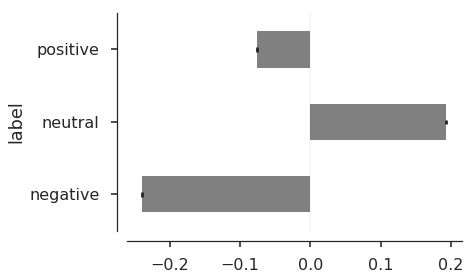

In [75]:
df_tt["SE"] = pd.concat([
    df_tt[["False", "True"]].mul(df_t.sum(axis=0)), (1-df_tt[["False", "True"]]).mul(df_t.sum(axis=0))
], axis=1).apply(lambda x: np.sqrt((1./(x + 0.5)).sum()), axis=1)
df_tt["log_odds"].plot(kind="barh", color="0.5", yerr=df_tt["SE"])
plt.axvline(x=0, linestyle="-", lw=0.1, color="0.4")
sns.despine(offset=10)

x         False   True
label                 
negative  25196  13443
neutral   29889  23086
positive  23442  16549
x            False      True  log_odds        SE
label                                           
negative  0.320858  0.253269 -0.236547  0.012572
neutral   0.380621  0.434945  0.133416  0.011431
positive  0.298522  0.311786  0.043476  0.012191


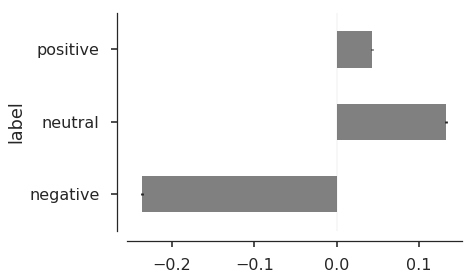

In [76]:
feature="u_has_url"
df_t = df.assign(
    x=df[feature].astype("str")
).pivot_table(columns="x", index="label", values="tid", aggfunc=len)
print(df_t)
df_tt = df_t.div(df_t.sum(axis=0), axis=1)
df_tt["log_odds"] = np.log(df_tt["True"]) - np.log(df_tt["False"])
df_tt["SE"] = pd.concat([
    df_tt[["False", "True"]].mul(df_t.sum(axis=0)), (1-df_tt[["False", "True"]]).mul(df_t.sum(axis=0))
], axis=1).apply(lambda x: np.sqrt((1./(x + 0.5)).sum()), axis=1)
print(df_tt)
df_tt["log_odds"].plot(kind="barh", color="0.5", yerr=df_tt["SE"])
plt.axvline(x=0, linestyle="-", lw=0.1, color="0.4")
sns.despine(offset=10)

u_verified
u_has_url
is_reply
is_quote


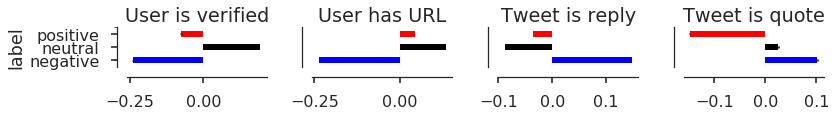

In [77]:
fig, ax = plt.subplots(1,4, sharey="row",
                       figsize=(12,2))


val_cols = ["u_verified", "u_has_url", "is_reply", "is_quote"]
x_labels = ["User is verified", "User has URL", "Tweet is reply", "Tweet is quote"]

ax = ax.flatten()

for i, feature in enumerate(val_cols):
    print(feature)
    plot_points_categorical(
        df, feature, "label",
        error=True,
        ax=ax[i],
        stacked=True, 
        color=color_order,
        xscale="linear"
    )
    ax[i].set_title(x_labels[i])
    if i > 0:
        ax[i].get_yaxis().set_visible(False)
#plt.legend(bbox_to_anchor=(1.0, 0.6))
#plt.xlim([-2,3])
sns.despine(offset=10)
fig.tight_layout()    

u_verified
u_has_url


/homed/content/anaconda3/lib/python3.6/site-packages/matplotlib/gridspec.py:306: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


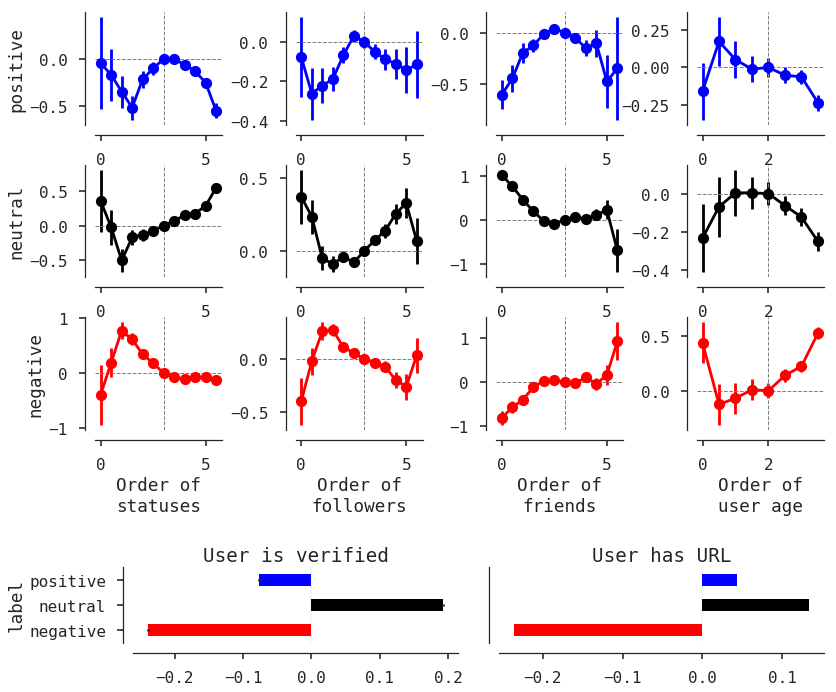

In [78]:
with sns.axes_style(rc={"font.family": "monospace"}):

    fig = plt.figure(figsize=(12,10))
    gs_user_num = gridspec.GridSpec(
        3,4,
    )
    gs_cat = gridspec.GridSpec(
        1,2,
    )

    ax = get_grid_axes(fig, gs_user_num)

    val_cols = ["u_statuses", "u_followers", "u_friends", "user_age"]
    x_labels = ["statuses", "followers", "friends", "user age"]

    for i, (label, color) in enumerate(
        zip(
            label_order,
            color_order
        )
    ):
        for j, feature in enumerate(val_cols):
            plot_points(df.assign(**{
                    feature: lambda x: np.log10((x[feature] + 1)),
                    "label": lambda x: (x["label"] == label)* 1.
                }), feature, "label", np.arange(-0.25,6.25,0.5), space_ticks=1,
                        error=True,
                        plot_logits=True,
                        color=color,
                        label=label, marker="o",
                        ax=ax[i, j],
                        yscale="linear")
            if i == 2:
                ax[i, j].set_xlabel("Order of\n%s" % x_labels[j])
            if j == 1:
                #ax[i, j].set_title(label.title())
                pass
            if j == 0:
                ax[i, j].set_ylabel(label.lower())  

    gs_user_num.tight_layout(fig, rect=[0, 0.25, 1, 1], h_pad=0.1, w_pad=0.1)
    ax = get_shared_y_axes(fig, gs_cat)

    val_cols = ["u_verified", "u_has_url", ]
    x_labels = ["User is verified", "User has URL",]

    ax = ax

    for i, feature in enumerate(val_cols):
        print(feature)
        plot_points_categorical(
            df, feature, "label",
            error=True,
            ax=ax[i],
            stacked=True, 
            color=color_order[::-1],
            xscale="linear"
        )
        ax[i].set_title(x_labels[i])
        if i > 0:
            ax[i].get_yaxis().set_visible(False)
    sns.despine(offset=10)
    gs_cat.tight_layout(fig, rect=[0, 0, 1, 0.25], h_pad=0., w_pad=1.5)
    #gs_user_num.tight_layout(fig)
    #gs_user_num.update(left=0.0, right=1, wspace=0.05)
    #fig.tight_layout()
    plt.savefig("figures/User_odds_ratio.pdf", bbox_inches="tight")

/homed/content/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:2967: RuntimeWarning: invalid value encountered in double_scalars
  low = [thisx - thiserr for (thisx, thiserr)
/homed/content/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in log
/homed/content/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:2969: RuntimeWarning: invalid value encountered in double_scalars
  high = [thisx + thiserr for (thisx, thiserr)


is_reply
is_quote


/homed/content/anaconda3/lib/python3.6/site-packages/matplotlib/gridspec.py:306: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


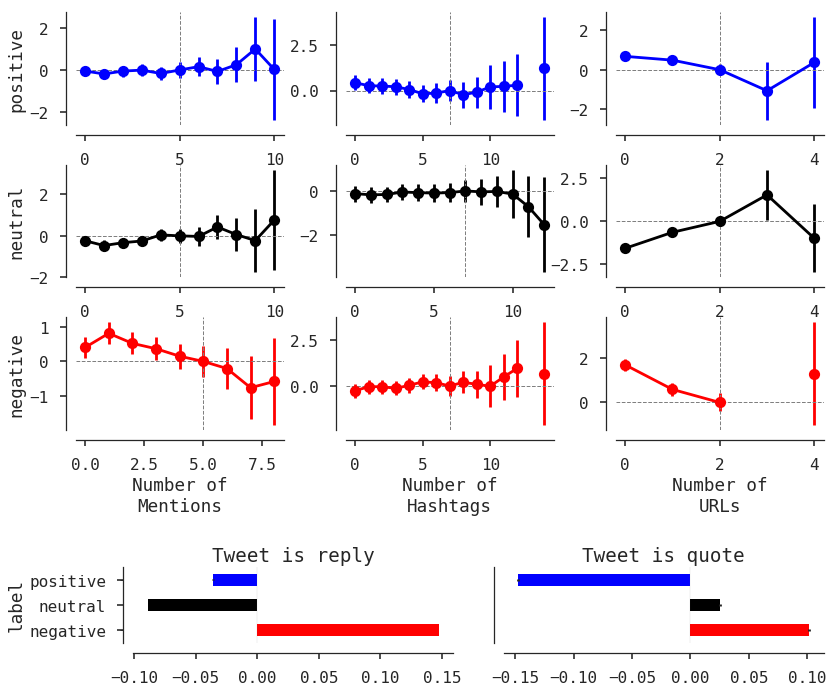

In [79]:
with sns.axes_style(rc={"font.family": "monospace"}):

    fig = plt.figure(figsize=(12,10))
    gs_tweet_num = gridspec.GridSpec(
        3,3,
    )
    gs_cat = gridspec.GridSpec(
        1,2,
    )

    ax = get_grid_axes(fig, gs_tweet_num)

    val_cols = ["n_mentions", "n_hashtags", "n_urls", ]
    x_labels = ["Mentions", "Hashtags", "URLs"]
    bins = [np.arange(-0.5, 11, 1),
            np.arange(-0.5, 15, 1), 
            np.arange(-0.5, 5, 1), 
           ]


    for i, (label, color) in enumerate(
        zip(
            label_order,
            color_order
        )
    ):
        for j, feature in enumerate(val_cols):
            plot_points(df.assign(**{
                    "label": lambda x: (x["label"] == label)* 1.
                }), feature, "label", bins[j], space_ticks=1,
                        error=True,
                        plot_logits=True,
                        color=color,
                        label=label, marker="o",
                        ax=ax[i, j],
                        yscale="linear")
            if i == 2:
                ax[i, j].set_xlabel("Number of\n%s" % x_labels[j])
            if j == 1:
                #ax[i, j].set_title(label.title())  
                pass
            if j == 0:
                ax[i, j].set_ylabel(label.lower())  

    gs_tweet_num.tight_layout(fig, rect=[0, 0.25, 1, 1], h_pad=0.1, w_pad=0.5)
    ax = get_shared_y_axes(fig, gs_cat)

    val_cols = ["is_reply", "is_quote"]
    x_labels = ["Tweet is reply", "Tweet is quote"]


    ax = ax

    for i, feature in enumerate(val_cols):
        print(feature)
        plot_points_categorical(
            df, feature, "label",
            error=True,
            ax=ax[i],
            stacked=True, 
            color=color_order[::-1],
            xscale="linear"
        )
        ax[i].set_title(x_labels[i])
        if i > 0:
            ax[i].get_yaxis().set_visible(False)
    sns.despine(offset=10)
    gs_cat.tight_layout(fig, rect=[0, 0, 1, 0.25], h_pad=0., w_pad=1.5)
    #gs_user_num.tight_layout(fig)
    #gs_user_num.update(left=0.0, right=1, wspace=0.05)
    #fig.tight_layout()
    plt.savefig("figures/Tweet_odds_ratio.pdf", bbox_inches="tight")